# Part II - Exploratory Data Analysis

University of San Diego - MS Applied AI

AAI-540 Team 5

October 21, 2024

# Introduction

### Project Overview
This project is dedicated to developing a predictive model for forecasting daily sales across various product families in the Favorita grocery store chain in Ecuador. Our main objective is to enhance inventory management and reduce waste by accurately predicting sales volumes. This will allow store managers and inventory planners to make informed decisions, ultimately improving business efficiency and customer satisfaction.

### Goals of the Project
The specific goals of this project are:
- To predict sales for each product family in multiple stores over the next 15 days.
- To identify key factors that influence sales, such as promotions, holidays, and external economic conditions.
- To provide a scalable solution that can be periodically updated with new data to continually refine the sales forecasts.

### Dataset Description
We are utilizing the "Store Sales - Time Series Forecasting" dataset from Kaggle, which includes:
- **train.csv**: Daily sales data, promotions, and other features.
- **stores.csv**: Metadata about each store.
- **oil.csv**: Daily oil prices, reflecting economic conditions.
- **holidays_events.csv**: Information on holidays and events.
These datasets encompass a comprehensive array of features that are pivotal in understanding sales dynamics within the retail space.

### Scope of This Notebook
This notebook, "2 - Exploratory Data Analysis.ipynb", focuses exclusively on the exploratory data analysis (EDA) of the project. The EDA is critical as it lays the foundation for all subsequent modeling work by helping us understand underlying patterns, detect outliers, and test hypotheses.

### EDA Steps
In this notebook, we will:
1. **Data Overview**: Quick visualization and statistical summary to understand the scales and nature of the data we are working with.
2. **Univariate Analysis**: Examine each variable individually to understand the distribution and detect any anomalies.
3. **Bivariate/Multivariate Analysis**: Explore the relationship between sales and other variables like promotions, oil prices, and holidays.
4. **Outlier Detection**: Identify any outliers in the dataset that could potentially skew the results.
5. **Preliminary Feature Selection**: Identify potential predictors for our forecasting model based on their correlation with sales.

Each step will be detailed with visual aids and statistical tests to ensure a comprehensive understanding of the data's characteristics and relationships.


## Setup and Data Loading

### Environment Setup

In [ ]:
# setup environment
%run 0-Environment_Setup.ipynb

### Load Data
We load our datasets from the S3 datalake and local storage for initial exploration. Here are the datasets and their initial inspection:

In [ ]:
s3_datalake_path_csv

's3://sagemaker-us-east-1-053585949834/store-sales-forecasting/csv'

In [ ]:
# Load data
holidays_df = wr.s3.read_csv(s3_datalake_path_csv + "/holidays_events.csv")
oil_df = wr.s3.read_csv(s3_datalake_path_csv + "/oil.csv")
transactions_df = wr.s3.read_csv(s3_datalake_path_csv + "/transactions.csv")
stores_df = wr.s3.read_csv(s3_datalake_path_csv + "/stores.csv")
sales_df = wr.s3.read_csv(s3_datalake_path_csv + "/train.csv")

2024-09-23 03:43:30,489	WARNING services.py:2009 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 411041792 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=0.85gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2024-09-23 03:43:31,798	INFO worker.py:1771 -- Started a local Ray instance.


In [3]:
# Load data pandas
import pandas as pd
# load from colab locaion

holidays_df =  pd.read_csv('/content/holidays_events.csv')
oil_df =  pd.read_csv('/content/oil.csv')
transactions_df =  pd.read_csv('/content/transactions.csv')
stores_df =  pd.read_csv('/content/stores.csv')
sales_df =  pd.read_csv('/content/train.csv')

## Initial Data Inspection

Each dataset is inspected to understand the structure, missing values, and potential issues that need addressing in preprocessing.



### Stores Dataset

In [4]:
# Display first 5 rows and column attributes
display(stores_df.head())
stores_df.info()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


#### Unique States and Cities
- We analyze the diversity and distribution of store locations, which could impact sales patterns due to regional differences.

In [5]:
# show unique states
unique_states = stores_df['state'].unique()
unique_states

array(['Pichincha', 'Santo Domingo de los Tsachilas', 'Cotopaxi',
       'Chimborazo', 'Imbabura', 'Bolivar', 'Pastaza', 'Tungurahua',
       'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja', 'El Oro',
       'Esmeraldas', 'Manabi'], dtype=object)

In [6]:
# show unique cities
unique_city = stores_df['city'].unique()
unique_city

array(['Quito', 'Santo Domingo', 'Cayambe', 'Latacunga', 'Riobamba',
       'Ibarra', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil', 'Salinas',
       'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad', 'Cuenca',
       'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen'],
      dtype=object)

In [7]:
# show unique type
stores_df['type'].unique()

array(['D', 'B', 'C', 'E', 'A'], dtype=object)

### Inspect Holidays

We convert dates to datetime and inspect the range, types of holidays, and their correlation with store locations.

#### Holiday Types and Date Range

In [8]:
# Convert dates to datetime
holidays_df['date'] = pd.to_datetime(holidays_df['date'])

# Display first 5 rows and column attributes
display(holidays_df.head())
holidays_df.info()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [9]:
holidays_df['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [10]:
# inspect date range and time steps for holidays
print("Date range for holidays:")
print("Start date: {}".format(holidays_df['date'].min()))
print("End date: {}".format(holidays_df['date'].max()))

Date range for holidays:
Start date: 2012-03-02 00:00:00
End date: 2017-12-26 00:00:00


In [11]:
holidays_df['locale'].unique()

array(['Local', 'Regional', 'National'], dtype=object)

In [12]:
# get unique locale_names
unique_locales = holidays_df['locale_name'].unique()
unique_locales

array(['Manta', 'Cotopaxi', 'Cuenca', 'Libertad', 'Riobamba', 'Puyo',
       'Guaranda', 'Imbabura', 'Latacunga', 'Machala', 'Santo Domingo',
       'El Carmen', 'Cayambe', 'Esmeraldas', 'Ecuador', 'Ambato',
       'Ibarra', 'Quevedo', 'Santo Domingo de los Tsachilas',
       'Santa Elena', 'Quito', 'Loja', 'Salinas', 'Guayaquil'],
      dtype=object)

In [13]:
# check for matches/overlap with holidays state values
for locale in unique_locales:
    if ((locale not in unique_city) and (locale not in unique_states)):
        print("Locale did not match city or state: {}".format(locale))


Locale did not match city or state: Ecuador


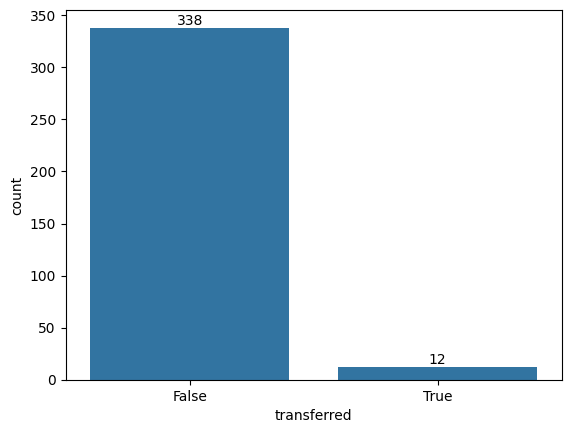

In [15]:
ax = sns.countplot(data=holidays_df, x='transferred')
ax.bar_label(ax.containers[0])
plt.show()

##### **Notes on Holidays and Locales**

The holidays seem to corrleate to either city or state level with one exception.  This would indicate that holidays can be mapped to stores based on these values - that is a holiday would be releveant to a store on a certain date if the locale matched either the city or state of the store.  This should be faciliated through the feature engineering process.

### Inspect Oil data

Contains the daily price of oil over the date range of interest
Oil prices are a critical economic indicator that may influence sales patterns, especially in an oil-dependent economy like Ecuador.


#### Oil Price Trends Over Time
- Visualization of oil price fluctuations.
- Discussion on how missing values were imputed and why.

In [16]:
# Convert dates to datetime
oil_df['date'] = pd.to_datetime(oil_df['date'])

# Display first 5 rows and column attributes
display(oil_df.head())
oil_df.info()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [17]:
# inspect date range and time steps for Oil
print("Time series summary for oil:")
print("Start date: {}".format(oil_df['date'].min()))
print("End date: {}".format(oil_df['date'].max()))
print("Number of time steps: {}".format(len(oil_df['date'].unique())))

Time series summary for oil:
Start date: 2013-01-01 00:00:00
End date: 2017-08-31 00:00:00
Number of time steps: 1218


In [18]:
# Check if the dates are consecutive
nonconsecutive_dates = len(oil_df[oil_df['date'].diff() > pd.Timedelta('1 days')])
print(f"Number of nonconsecutive dates for oil: {nonconsecutive_dates}")

Number of nonconsecutive dates for oil: 243


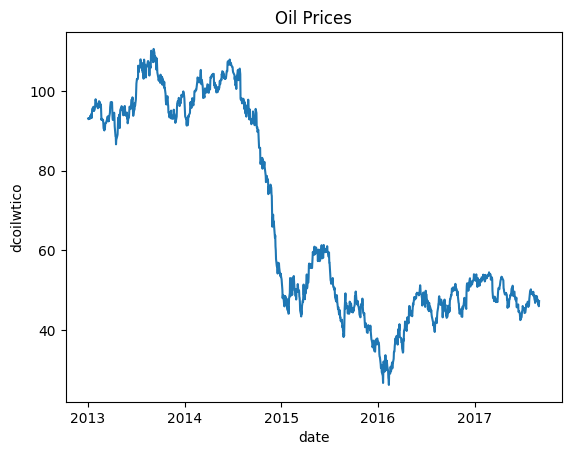

In [19]:
# visualize oil prices
sns.lineplot(data=oil_df, x='date', y='dcoilwtico')
plt.title('Oil Prices')
plt.show()

In [20]:
# Impute the missing values for oil prices by backfilling them
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].bfill()
oil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1218 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


##### **Notes on Oil Prices**

The oil dataset provides the daily price of oil for the date range of interest for our store sales.  The price of oil can be engineered as a feature to be included with each sample at the day level.

Juliet: Since oil prices don't change significantly from day to day, I used a backward fill to impute the missing values. Another thing to note is that not all of the dates are consecutive, so when merging this data with the other data we have to decide whether to treat the dates that are not included as missing values or not.

### Inspect Transactions

#### Transaction Trends and Anomalies
- We look for non-consecutive dates, anomalies in transaction volumes, and seasonal patterns.

In [21]:
# Convert dates to datetime
transactions_df['date'] = pd.to_datetime(transactions_df['date'])

# Display first 5 rows and column attributes
display(transactions_df.head())
transactions_df.info()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [22]:
# inspect date range and time steps for Transactions
print("Time series summary for transactions:")
print("Start date: {}".format(transactions_df['date'].min()))
print("End date: {}".format(transactions_df['date'].max()))
print("Number of time steps: {}".format(len(transactions_df['date'].unique())))

Time series summary for transactions:
Start date: 2013-01-01 00:00:00
End date: 2017-08-15 00:00:00
Number of time steps: 1682


In [ ]:
# Check if there are nonconsecutive dates
nonconsecutive_dates = len(transactions_df[transactions_df['date'].diff() > pd.Timedelta('1 days')])
print(f"Number of nonconsecutive dates for transactions: {nonconsecutive_dates}")

Number of nonconsecutive dates for transactions: 6


#### graph

In [ ]:
# create a grouped df by store to visualize
transactions_df_grouped = transactions_df.groupby(['store_nbr', pd.Grouper(key='date', freq='D')]).max()

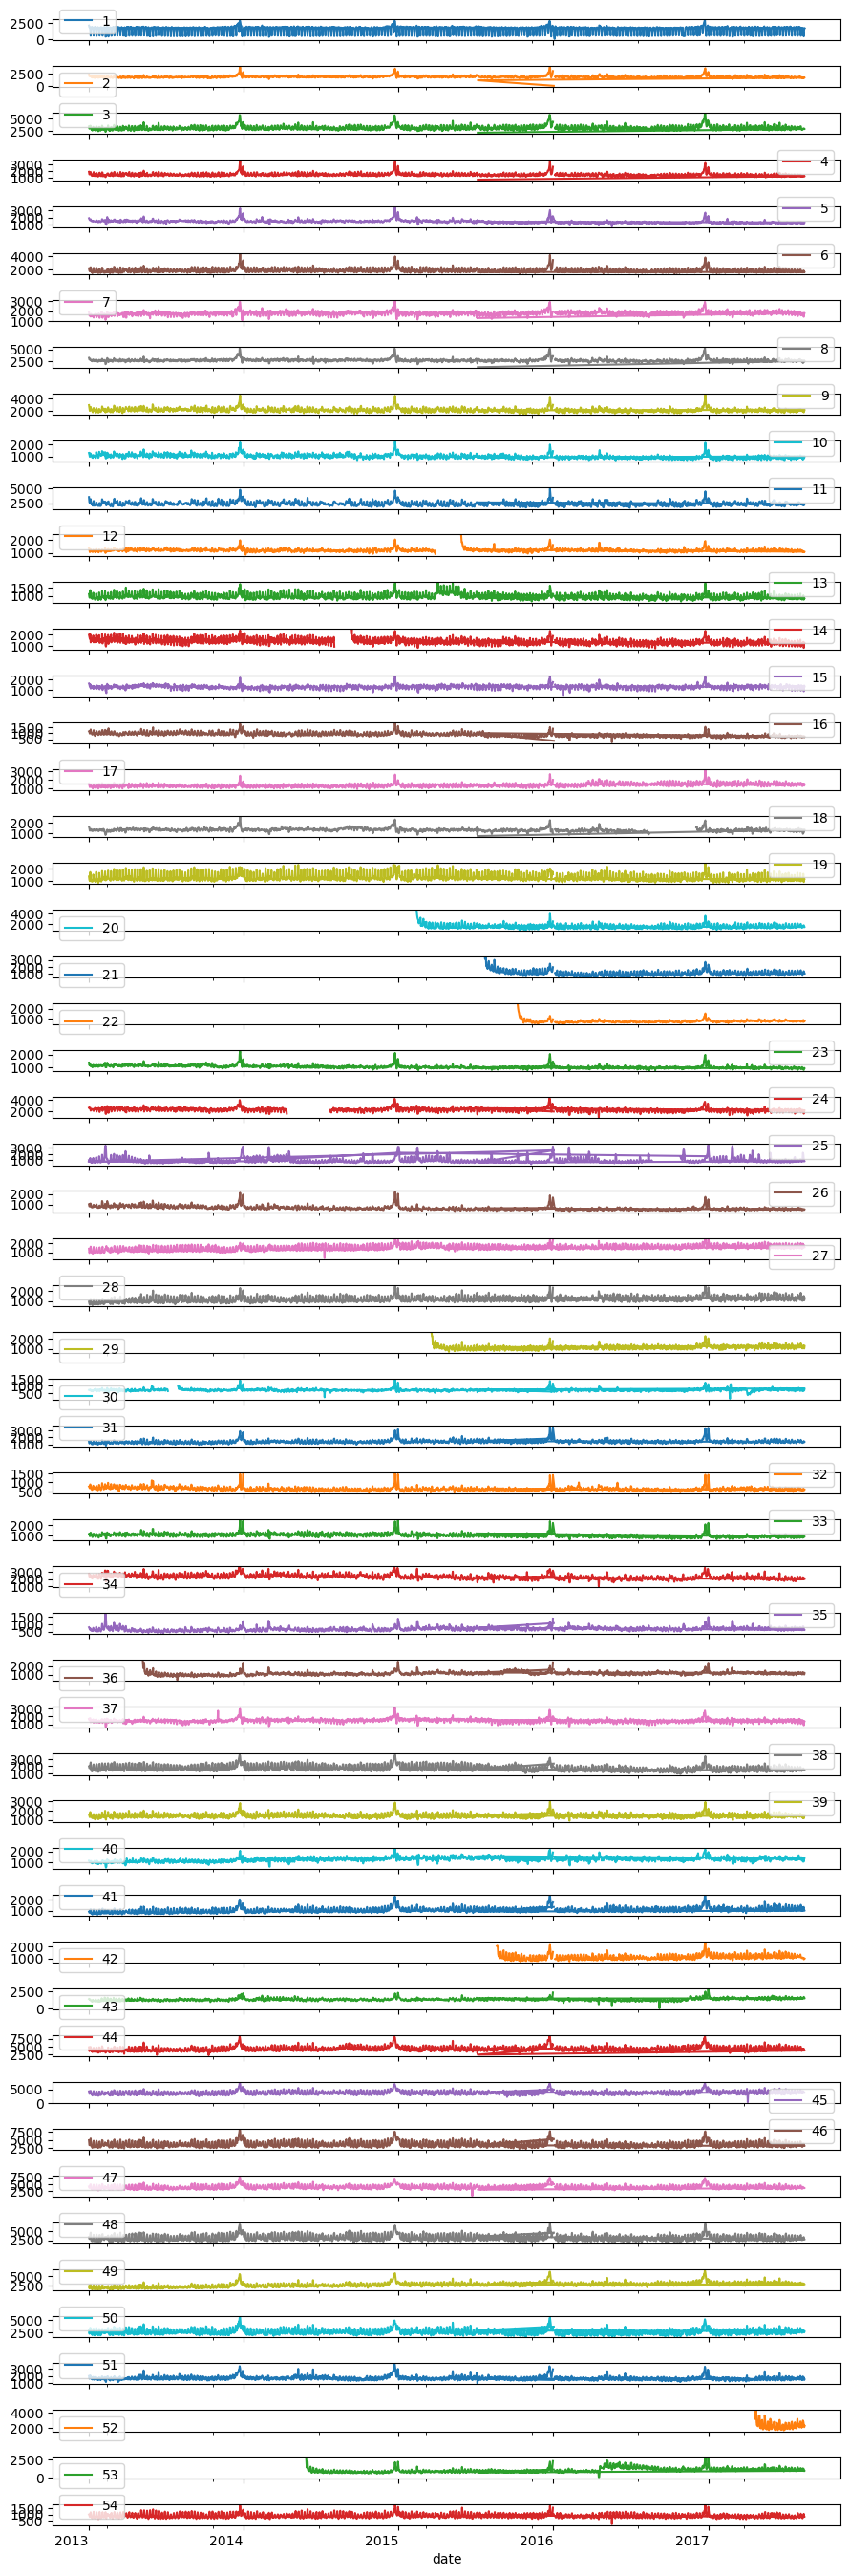

In [ ]:
# plot total transactions by store
ax = transactions_df_grouped.unstack(level=0).plot(kind='line', y='transactions', subplots=True, rot=0, figsize=(9, 27))
plt.tight_layout()

##### **Notes on Transactions**

Several observations can be made based on the exploration and visualization of the transaction data:

1.  The data is collected at a 1 day resolution at the store level.
2. We clearly have several stores that came online during our time period of interest.  We will need to take this into consideration when creating sequences for these stores (ie: Stores 20, 21, 22 as examples)
3. There are some cases where data is missing.  For example, Store 25 shows a clear data gap around late 2016.  This will also need to be handled in data preparation.
4.  We can clearly see seasonal spikes in the volume of transactions around the holiday at the end of each year.

Juliet: We could consider using transactions as the target instead of sales.

### Inspect Store Sales

#### Sales Trends by Store and Product Category
- Visual representation of sales volumes over time, highlighting any correlations with transaction data and holidays.

In [23]:
# Convert dates to datetime
sales_df['date'] = pd.to_datetime(sales_df['date'])

# Display first 5 rows and column attributes
display(sales_df.head())
sales_df.info()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [24]:
# Drop the id column
sales_df.drop(columns=['id'], inplace=True)

In [25]:
# inspect date range and time steps for sales
print("Time series summary for sales:")
print("Start date: {}".format(sales_df['date'].min()))
print("End date: {}".format(sales_df['date'].max()))
print("Number of time steps: {}".format(len(sales_df['date'].unique())))

Time series summary for sales:
Start date: 2013-01-01 00:00:00
End date: 2017-08-15 00:00:00
Number of time steps: 1684


In [26]:
# Check if there are nonconsecutive dates
nonconsecutive_dates = len(sales_df[sales_df['date'].diff() > pd.Timedelta('1 days')])
print(f"Number of nonconsecutive dates for sales: {nonconsecutive_dates}")

Number of nonconsecutive dates for sales: 4


In [27]:
# inspect how many stores
print("Number of stores: {}".format(len(sales_df['store_nbr'].unique())))

Number of stores: 54


In [28]:
# inspect how many product categories
print("Number of product categories: {}".format(len(sales_df['family'].unique())))

Number of product categories: 33


In [29]:
# create a grouped df by store to visualize
sales_df['date'] = pd.to_datetime(sales_df['date'])
sales_df_grouped = sales_df.groupby(['store_nbr', pd.Grouper(key='date', freq='D')]).sum()

#### graph

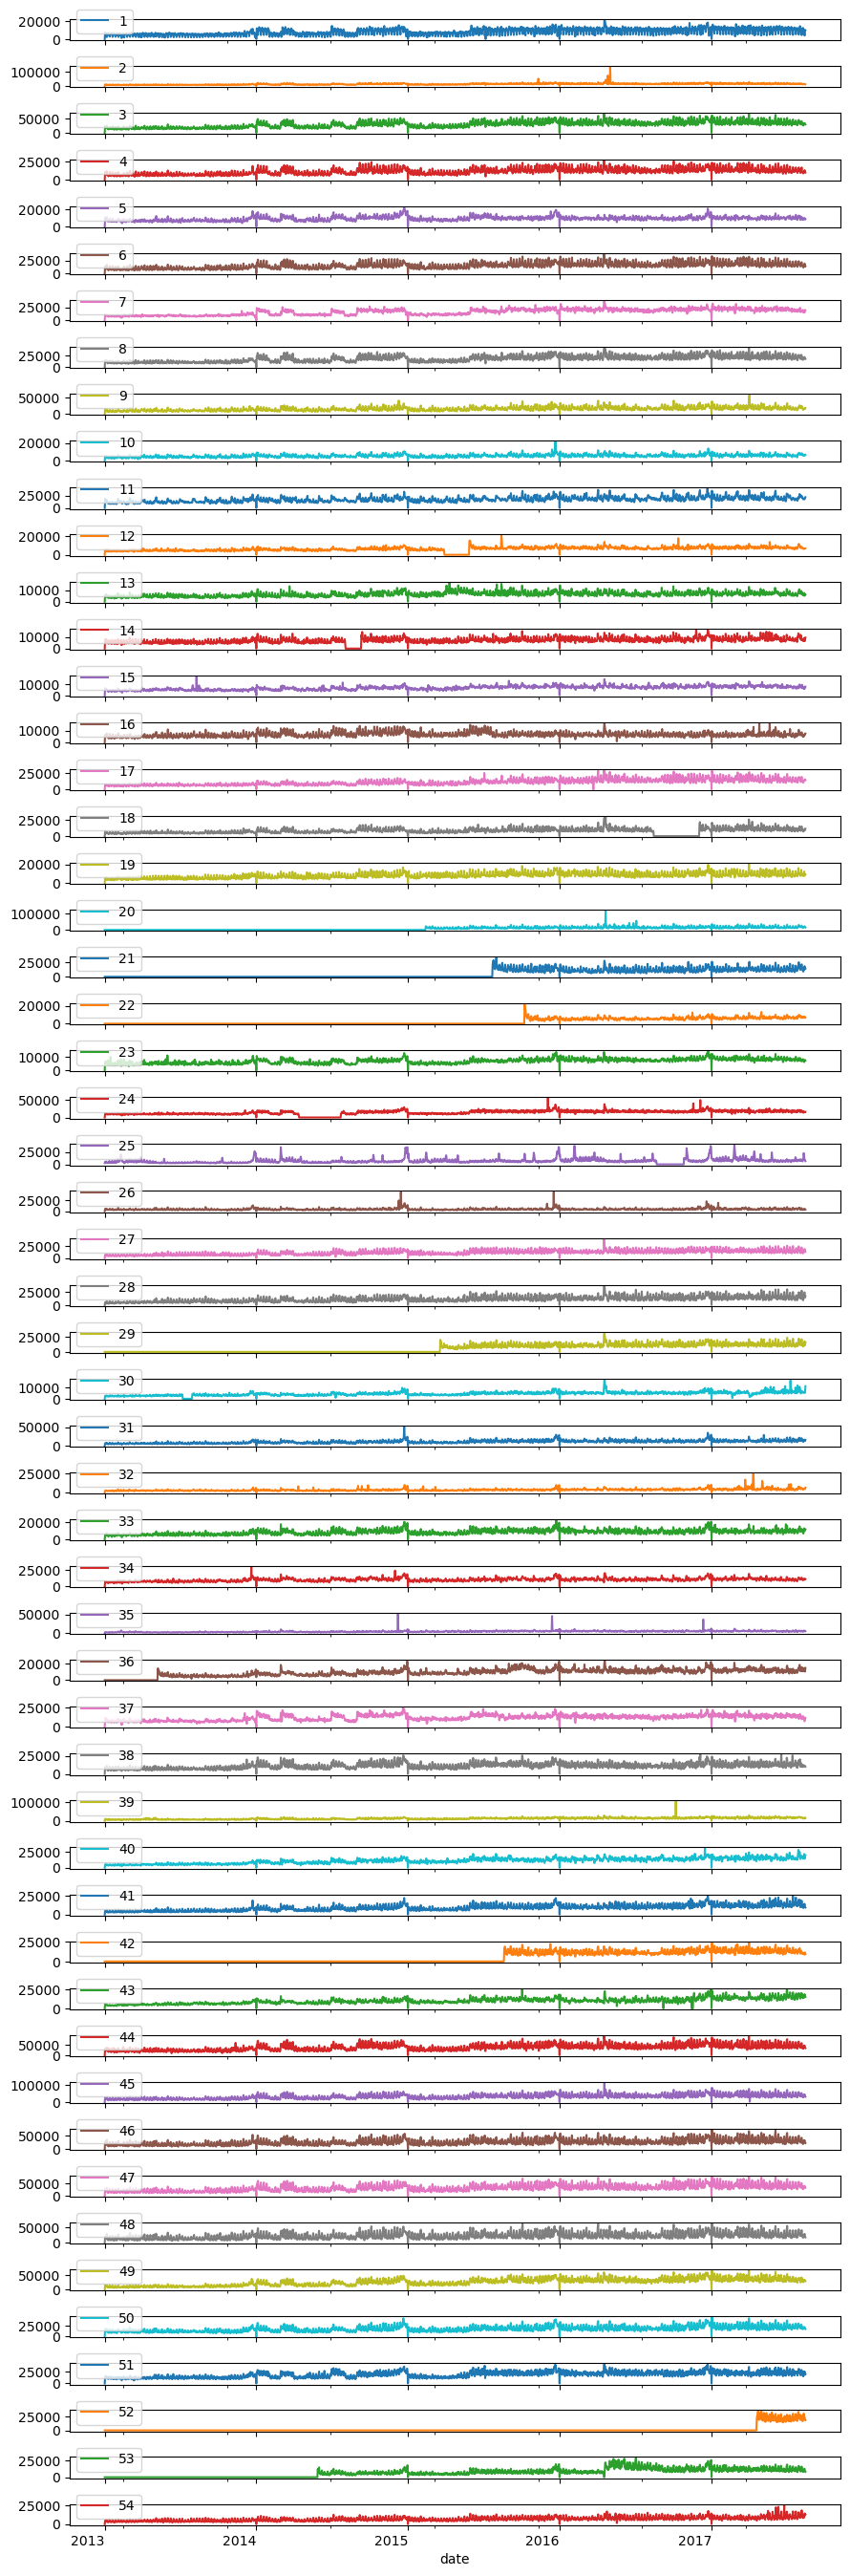

In [ ]:
# plot total sales by store
ax = sales_df_grouped.unstack(level=0).plot(kind='line', y='sales', subplots=True, rot=0, figsize=(9, 27))
plt.tight_layout()

##### **Notes on Store Sales**

The store data was rolled up to total sales at a store level, not broken down by product category to aid in visualization.  Several observations can be made based on the exploration and visualization of the store sales data:

1. The sales data is similarly on a daily time step.  However, store data is further broken down by product category (not visualized in the graphs).
1. As observed in transactions, we clearly have several stores that came online during our time period of interest.  We will need to take this into consideration when creating sequences for these stores (ie: Stores 52 and 53 as examples)
2. The same data gaps are present for what appears to be the same stores as observed in the transactions data.
3.  There seems to be a more gradual ramp of sales leading up to the holidays, followed by a drop at the beginning of each year.



## Summary and Preliminary Insights

### Key Findings
- Summary of critical insights from the data.
- Discussion on how these insights will direct the feature engineering and model training phases.



**General Notes**

Based on EDA so far, an approach for data loading and preparation is presenting itself.  One possible approach could look like the following:

1.   Load all data into a datalake
2.   Extract all unique locales from holiday dataset into additional metadata table
3.   Create index fields in both store table and holiday table to reference the appropriate locale ID
4.   Create an index field to link store_br in transactions and sales to stores metadata table
5.   Create a query that returns a view of the sales data that for each sales data sample:
    
    a) Store metadata/locale is pulled from store metadata (by store_nbr)
    b) Whether there is a holiday or not is pulled from holiday (by locale)
    c) Price of oil data for that day is pulled from oil table (by date)
    d) Number of transactions for the store is pulled from transactions (by store_nbr + date)

## Expanded EDA
Let's continue with our exploratory data analysis by diving deeper into understanding the relationships between different data sources and how they influence sales. We'll specifically look at the relationships between store characteristics, holidays, oil prices, and transaction volumes—all aimed at helping us create the best model for forecasting sales at the store level for the next 7 days.

### Analysis of Sales by Store Characteristics

This section explores how store characteristics such as type and cluster influence total sales volumes. By understanding these trends, we can determine which types of stores or clusters have the highest sales and create store-specific features for our forecasting model.


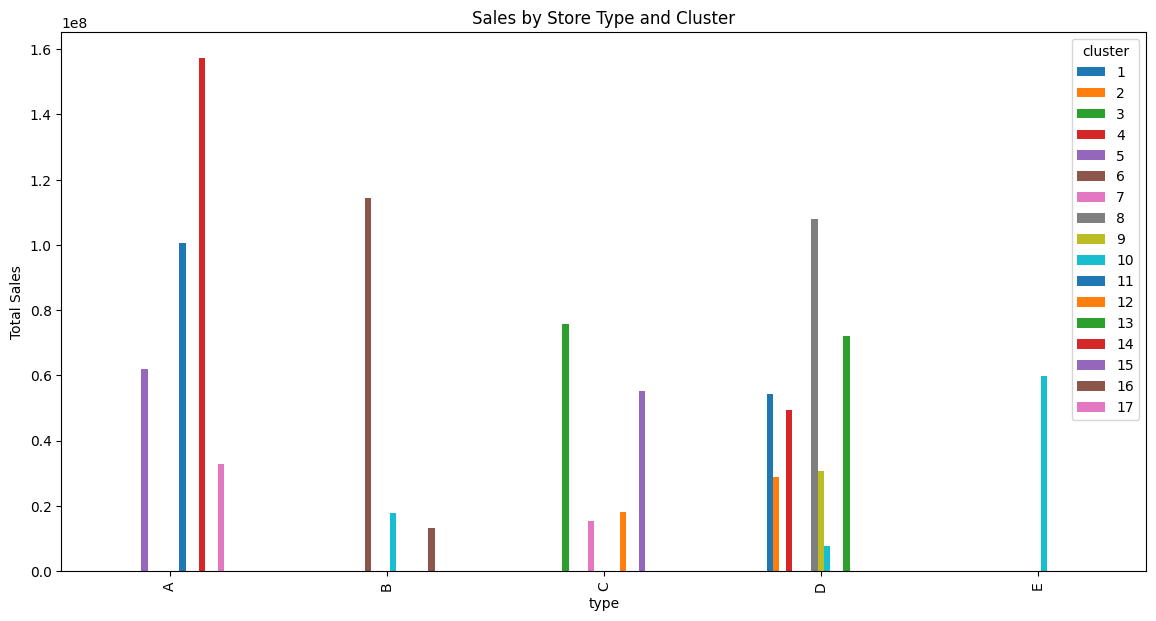

In [30]:
# Merging store data with sales data
store_sales_df = pd.merge(sales_df, stores_df, on='store_nbr', how='left')

# Grouping by store type and cluster, then summarizing sales
store_type_sales = store_sales_df.groupby(['type', 'cluster'])['sales'].sum().unstack()
store_type_sales.plot(kind='bar', figsize=(14, 7), title='Sales by Store Type and Cluster')
plt.ylabel('Total Sales')
plt.show()


#### Observations from the Sales by Store Characteristics Plot

- **Store Type A** has the highest sales overall, especially for clusters **4** and **1**, indicating that these types of stores might serve larger markets or have more popular products.
- **Store Type D** also contributes significantly across different clusters, with noticeable sales in clusters **8**, **13**, and **15**.
- **Store Types B, C, and E** show comparatively lower sales volumes across their respective clusters, which could mean they are smaller stores or cater to less populous areas.

#### Insights for Feature Engineering

- We could create a **"store type"** feature to capture the impact of different store types on sales. This may be especially useful for our model since store type A clearly outperforms other types.
- We could also consider grouping clusters based on their sales performance to create a **"high-sales cluster"** flag, which could help our model differentiate between high and low-performing locations.


### Holiday Impact on Sales

In this section, we analyze sales performance during local, regional, and national holidays to understand their impact on sales volumes. We want to determine if there are significant sales differences on holidays versus non-holidays, which will help us create holiday-related features that improve our forecasting model.


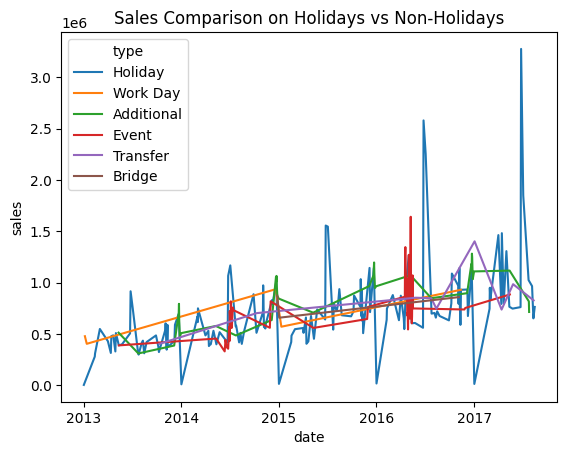

In [31]:
# Convert sales and holiday dates to datetime if not already
sales_df['date'] = pd.to_datetime(sales_df['date'])
holidays_df['date'] = pd.to_datetime(holidays_df['date'])

# Merging holiday info with sales data
sales_holidays_df = pd.merge(sales_df, holidays_df, on='date', how='left')

# Checking sales performance on holidays vs non-holidays
holiday_sales_comparison = sales_holidays_df.groupby(['date', 'type'])['sales'].sum().reset_index()
sns.lineplot(data=holiday_sales_comparison, x='date', y='sales', hue='type')
plt.title('Sales Comparison on Holidays vs Non-Holidays')
plt.show()


##### **Observations from the Holiday Impact Plot**

- **Holiday Effect**: Sales tend to increase significantly on major holidays, as indicated by the spikes in the blue line (`Holiday`). This suggests that holidays play a crucial role in influencing consumer behavior and boosting sales.
- **Work Days vs. Holidays**: The orange line (`Work Day`) shows more consistent but lower sales levels compared to holidays, indicating a predictable baseline, while holiday sales are more variable and often higher.
- **Events and Transfers**: Sales during events (`Event`) and transferred holidays (`Transfer`) show occasional peaks, which implies that these might also affect sales positively but not as consistently as holidays.
- **Seasonality**: Notable peaks appear during end-of-year holiday periods, which aligns with typical retail behavior where the holiday season drives higher sales.

##### **Insights for Feature Engineering**

- Create a **"holiday flag"** feature that indicates whether a particular date is a holiday or a workday.
- Add a **"holiday type"** feature to distinguish between local, regional, national holidays, events, and transferred holidays, given their varying impacts on sales.
- Create a **"days to next holiday"** feature to capture consumer anticipation leading up to significant holidays.

Now that we've identifeid trends in the hlidyas lets expore if the days around the holidays are also impacted


#### **Sales Trend Leading Up to and After Holidays**

Next, we'll explore how sales change in the days leading up to and following holidays. This analysis will help determine if a lead or lag effect exists, which we can leverage for feature engineering.



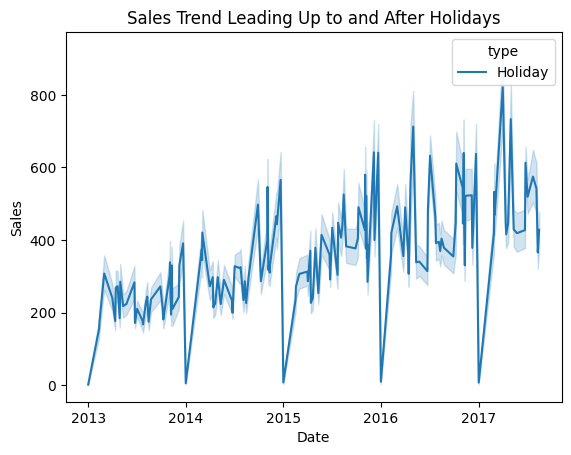

In [33]:
# Create a lead and lag window around holidays (e.g., 7 days before and 7 days after)
from datetime import timedelta

# Adding flags for days leading up to holidays and days after holidays
sales_holidays_df['is_leadup'] = sales_holidays_df.apply(lambda x: x['date'] >= x['date'] - timedelta(days=7) and x['type'] == 'Holiday', axis=1)
sales_holidays_df['is_lag'] = sales_holidays_df.apply(lambda x: x['date'] <= x['date'] + timedelta(days=7) and x['type'] == 'Holiday', axis=1)

# Extracting sales for lead-up, holiday, and post-holiday periods
lead_lag_sales = sales_holidays_df[sales_holidays_df['is_leadup'] | sales_holidays_df['is_lag'] | (sales_holidays_df['type'] == 'Holiday')]

# Plotting the sales trends around holidays
sns.lineplot(data=lead_lag_sales, x='date', y='sales', hue='type')
plt.title('Sales Trend Leading Up to and After Holidays')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


##### **Observations from the Sales Trend Leading Up to and After Holidays Plot**

- **Pre-Holiday Sales Build-Up**: Sales increase in the days leading up to holidays, reflecting consumer preparation behavior. This is particularly noticeable as we approach major holiday periods.
- **Sales Spikes During Holidays**: There are prominent peaks during holidays, which indicates that major holidays drive significant spikes in sales.
- **Post-Holiday Sales Decline**: There is a dip in sales following holidays, indicating a cooling-off period after increased holiday spending.
- **Seasonality Effect**: The consistent pattern every year, especially at the end of the year, indicates a strong seasonal component affecting sales.

##### **Insights for Feature Engineering**

- **Lead-Up Days Feature**: Create a feature to indicate whether a day is within a certain number of days leading up to a holiday (e.g., 7 days before).
- **Post-Holiday Lag Feature**: Add a feature for the post-holiday lag effect to account for the expected decline in sales.


- **Key feature Seasonality Capture**: Incorporate seasonal dummy variables like month and week to help the model understand the time of the year and capture seasonal trends.

Based on our initial analysis we can now explore differnt aspects of holidays


 #### **Analysis of Sales by Holiday Type**

In this section, we further analyze the impact of different holiday types on sales volumes. By understanding which types of holidays lead to the highest sales, we can refine our features to focus on specific holiday categories.


<ipython-input-32-f84302ca963b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=holiday_type_sales, x='type', y='sales', palette='viridis')


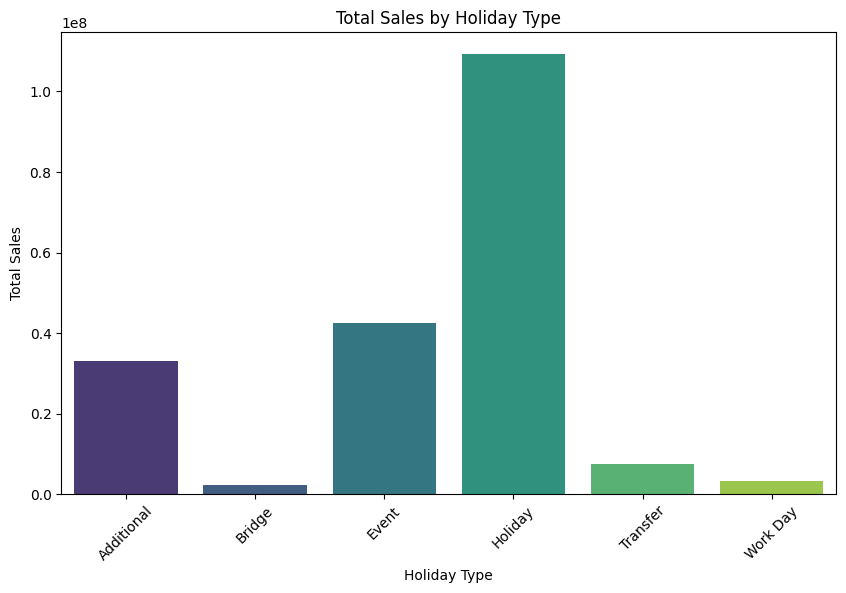

In [32]:
# Grouping sales by holiday type to understand the sales impact of each type
holiday_type_sales = sales_holidays_df.groupby('type')['sales'].sum().reset_index()

# Plotting the total sales by each holiday type
plt.figure(figsize=(10, 6))
sns.barplot(data=holiday_type_sales, x='type', y='sales', palette='viridis')
plt.title('Total Sales by Holiday Type')
plt.ylabel('Total Sales')
plt.xlabel('Holiday Type')
plt.xticks(rotation=45)
plt.show()


##### **Observations from the Total Sales by Holiday Type Plot**

- **Holiday Type Dominance**: The **Holiday** category shows the highest total sales, significantly surpassing other types, indicating that major holidays are key drivers of sales.
- **Event and Additional Holidays**: The **Event** and **Additional** categories also show substantial sales, although not as high as major holidays, suggesting moderate consumer spending increases.
- **Bridge and Transfer Holidays**: These holidays have much lower total sales, indicating they are less impactful on consumer spending.
- **Work Days**: Lower sales on **Work Days** compared to holidays confirm that consumer behavior is different during holidays, leading to increased spending.


#### **Holiday Sales by Store Type**

Lastly we'll analyze the interaction between holiday sales and store types to understand if certain store types are more influenced by holidays. This can help us develop store-type-specific holiday features.


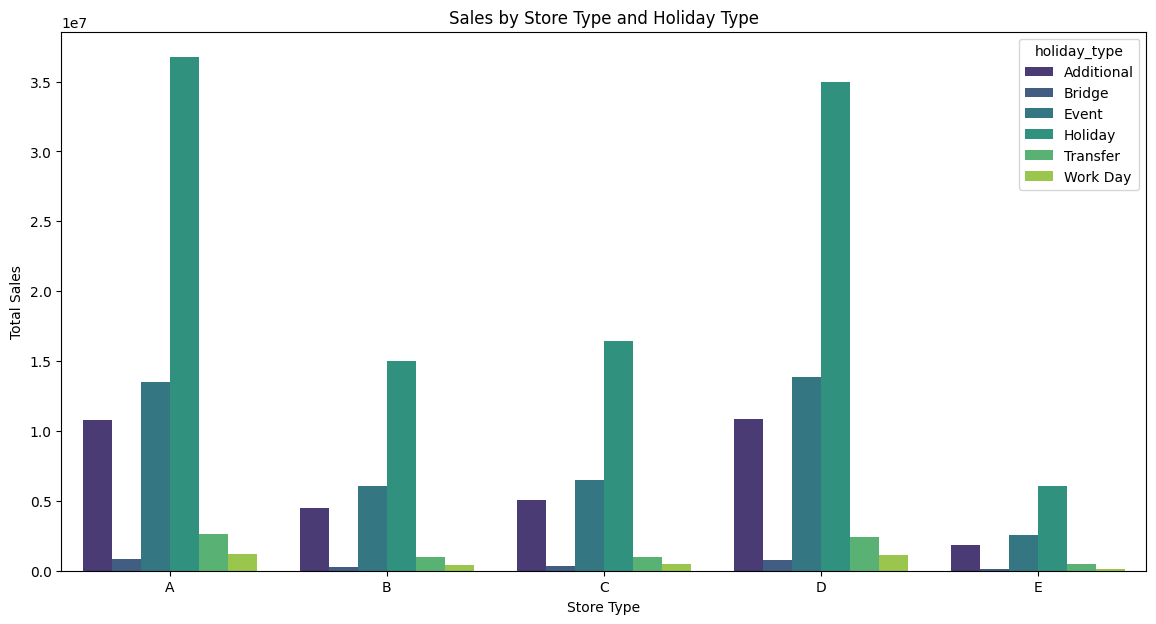

In [38]:
# Renaming the 'type_x' column to 'holiday_type' for better clarity
holiday_store_sales.rename(columns={'type_x': 'holiday_type'}, inplace=True)

# Grouping by store type (type_y from stores_df) and holiday type (holiday_type from holidays_df) to see if there are differences in sales
holiday_store_type_sales = holiday_store_sales.groupby(['type_y', 'holiday_type'])['sales'].sum().reset_index()

# Plotting the sales by store type and holiday type
plt.figure(figsize=(14, 7))
sns.barplot(data=holiday_store_type_sales, x='type_y', y='sales', hue='holiday_type', palette='viridis')
plt.title('Sales by Store Type and Holiday Type')
plt.ylabel('Total Sales')
plt.xlabel('Store Type')
plt.show()


#### Analysis of Sales by Holiday Type and Locale

Now that we've seen the trends of holiday sales accross the years lets analyze the impact of different holiday types (`National`, `Regional`, `Local`) on sales volumes. In our Inital EDA we saw that holidays were broekn up by local and type so now  we aim to understand if holidays at different levels have varying impacts on sales in specific locales (cities and states).


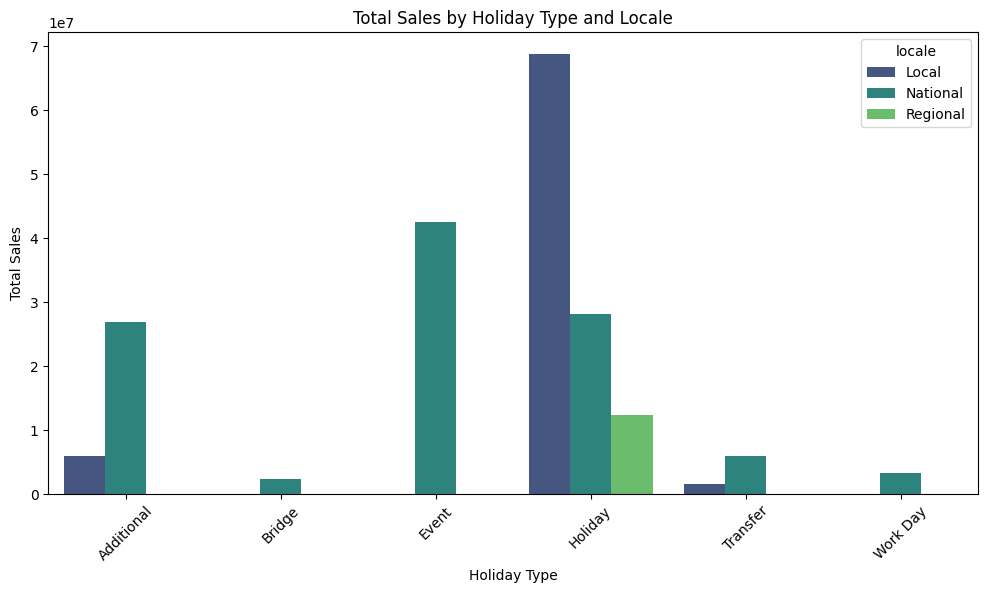

In [41]:
# Grouping sales by holiday type (type) and locale to understand their impact on sales
holiday_locale_sales = sales_holidays_df.groupby(['type', 'locale'])['sales'].sum().reset_index()

# Plotting the total sales by holiday type and locale
plt.figure(figsize=(12, 6))
sns.barplot(data=holiday_locale_sales, x='type', y='sales', hue='locale', palette='viridis')
plt.title('Total Sales by Holiday Type and Locale')
plt.ylabel('Total Sales')
plt.xlabel('Holiday Type')
plt.xticks(rotation=45)
plt.show()


##### **Observations from the Total Sales by Holiday Type and Locale Plot**

- **National Holidays Drive the Highest Sales**: National holidays have the highest impact on sales across holiday types, showing that they lead to the highest consumer spending.
- **Local Holidays Impact**: Local holidays also have a significant impact, particularly during major holidays and events, leading to increased sales in specific areas.
- **Regional Holidays Have Moderate Impact**: Regional holidays contribute moderately to sales but show a lower impact compared to national and local holidays.
- **Bridge and Transfer Holidays**: These holidays contribute minimally to sales, indicating that they have little effect on overall sales volumes.

##### **Insights for Feature Engineering**

- **Holiday Type and Locale Interaction**: Create a feature to capture the interaction between holiday type and locale to capture varying impacts.
- **National Holiday Flag**: Create a specific flag for National holidays to indicate periods of high sales.
- **Local and Regional Holiday Effect**: Include separate features for local and regional holidays, linked to store-level information.
- **Weight Holidays Based on Locale**: Assign weights to holidays based on their locale, with National holidays weighted higher.


##### **Observations from the Sales by Store Type and Holiday Type Plot**

- **Store Type A and D again show dominance**: Store Types A and D have the highest sales across most holiday types, especially during **Holidays** and **Events**.
- **Holiday Type Impact**:
  - **Holidays** drive the highest sales for all store types, particularly for **Store Types A and D this also corilates with the store sales, indicating that these types of stores have higher overall sales numbers**.
  - **Events** also contribute significantly to sales across store types, although less than major holidays.
  - **Additional Holidays** have a moderate impact, but not as much as **Holidays** or **Events**.
  - **Bridge**, **Transfer**, and **Work Days** show comparatively lower sales, indicating they are less impactful.

Okay so now that we've seen the distribution of holiday types by locale we can expore the effects on certain citys


#### Sales by Store Type and Location During Holidays

 We'll now analyze the interaction between holiday sales and store types across different locations. We aim to understand if store types in certain locations are more influenced by holidays than others, which will help us derive store-type-specific holiday features.


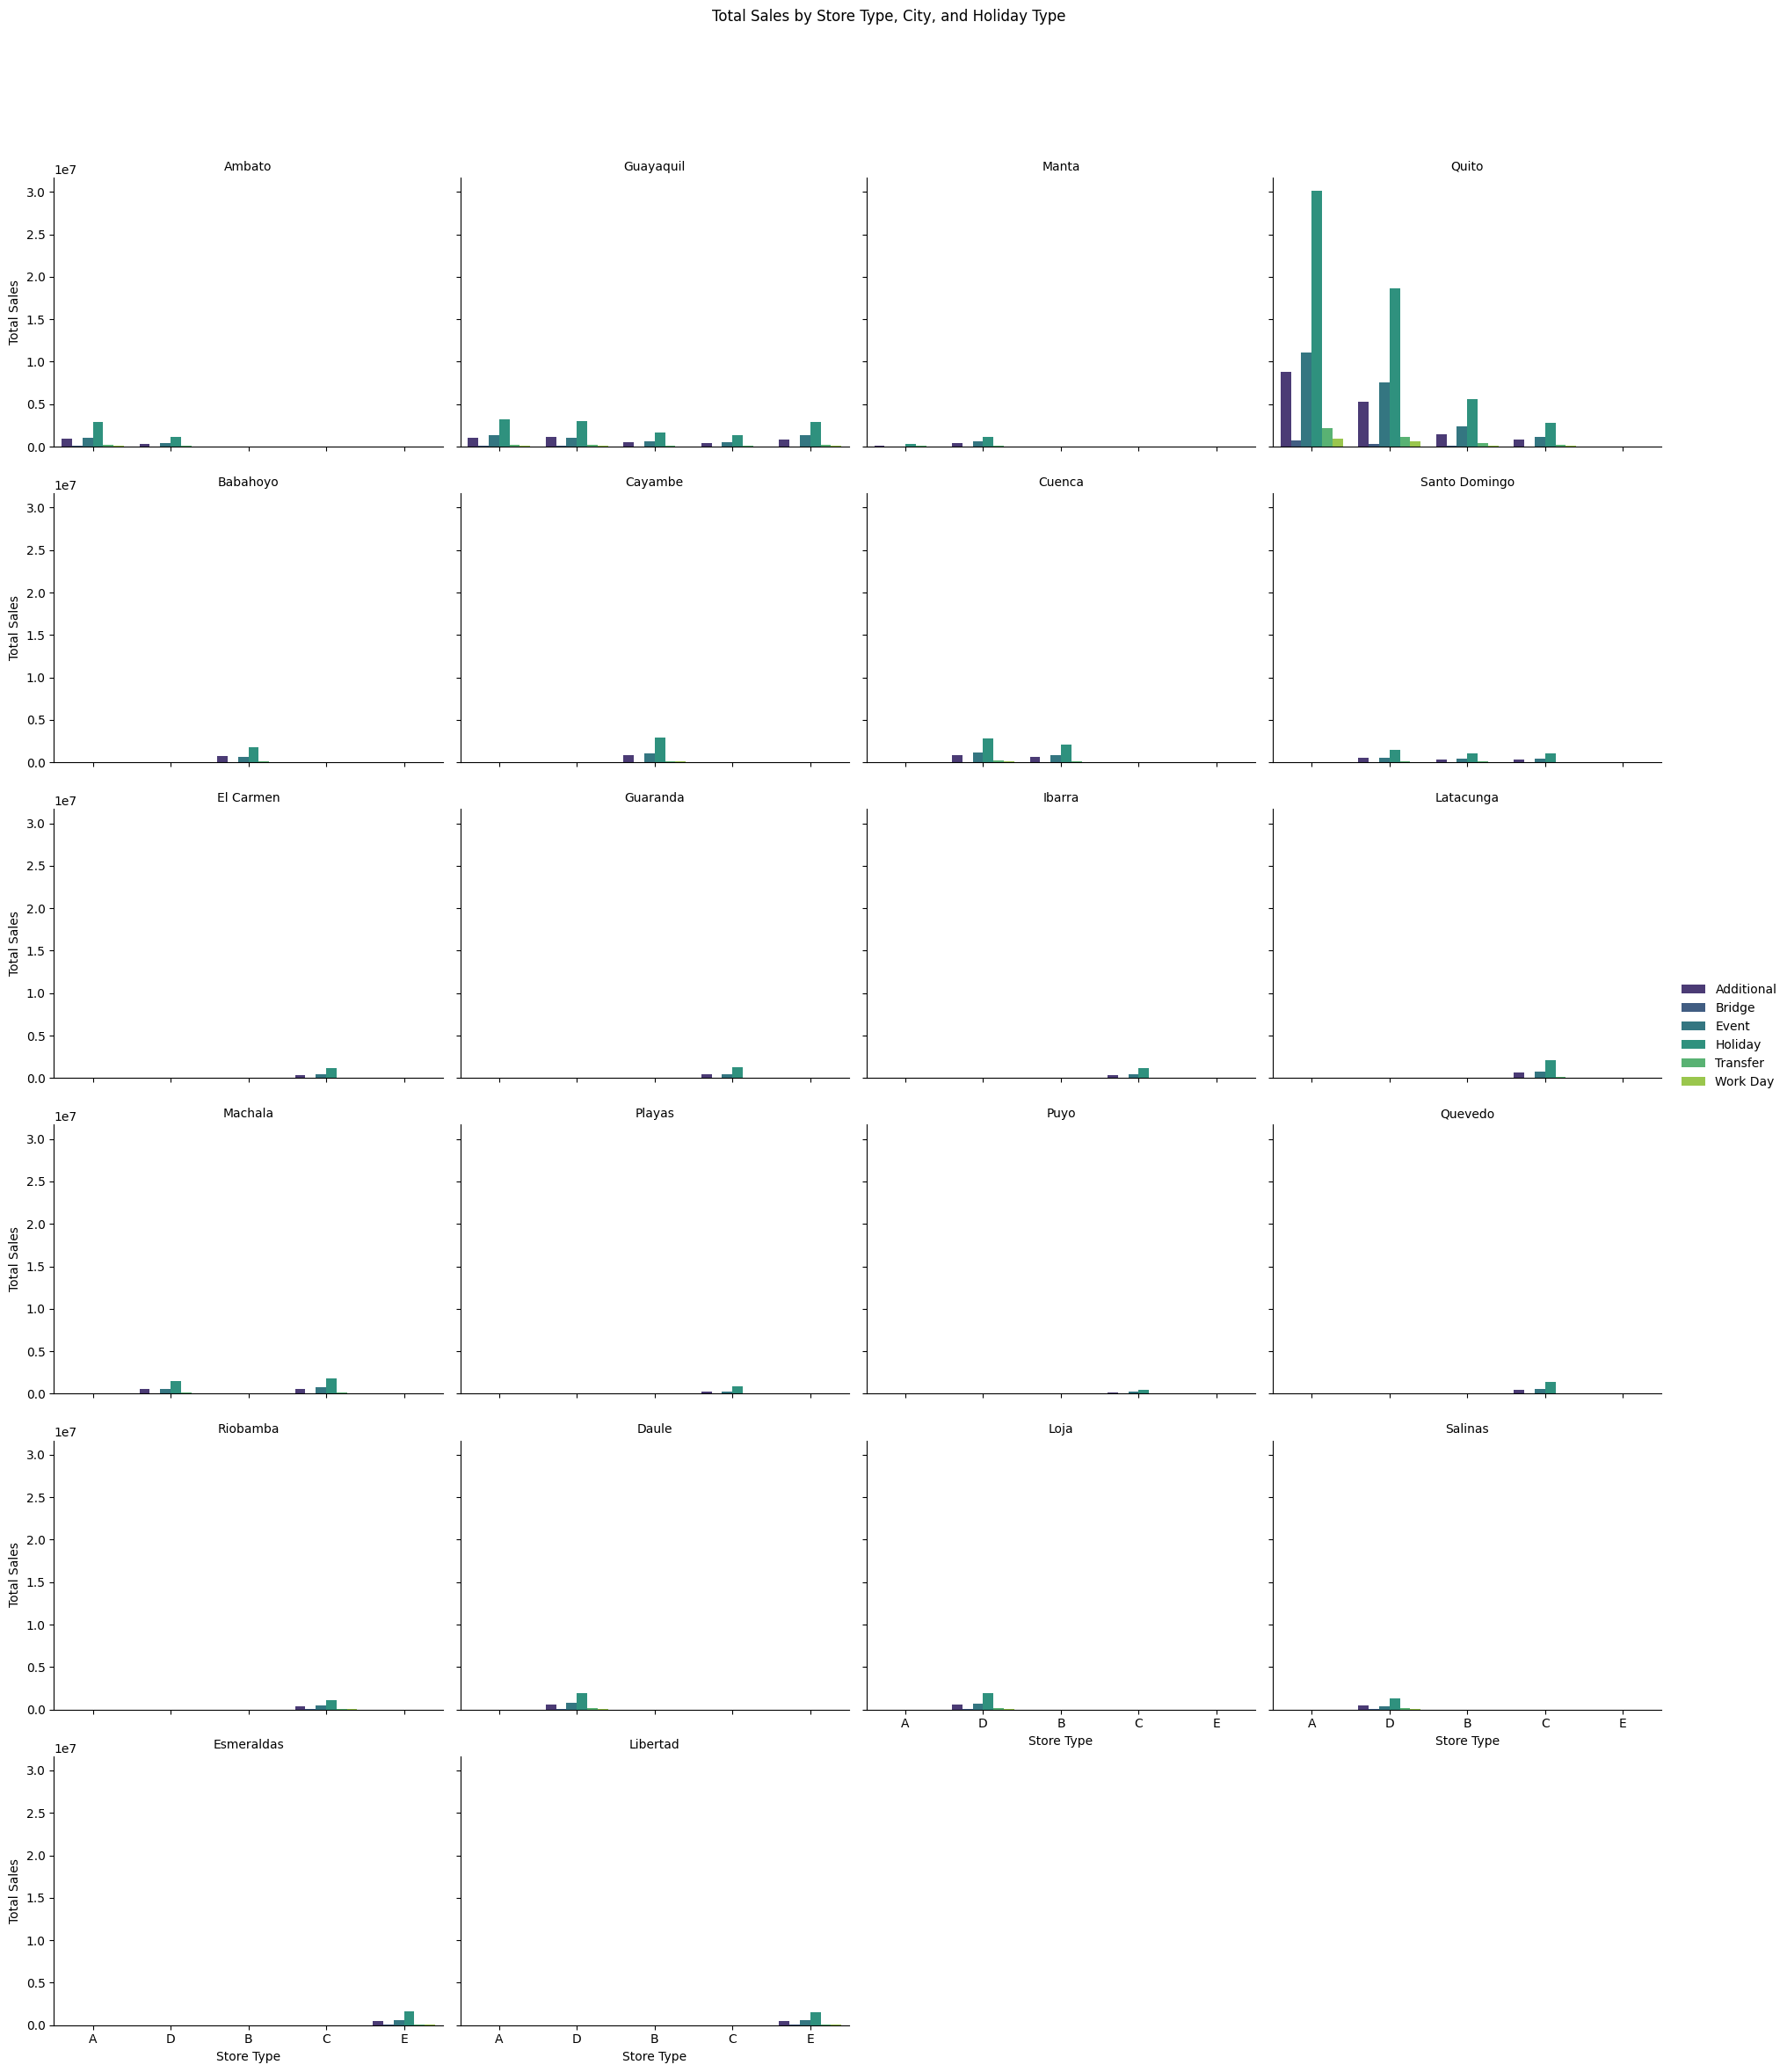

In [66]:
# Adjusting the data for FacetGrid plotting by grouping by store type, city, and holiday type
store_holiday_location_sales = holiday_store_sales.groupby(['type_y', 'city', 'type_x'])['sales'].sum().reset_index()

# Using a FacetGrid to plot sales by store type, city, and holiday type
g = sns.FacetGrid(store_holiday_location_sales, col='city', col_wrap=4, height=4, aspect=1.2)
g.map_dataframe(sns.barplot, x='type_y', y='sales', hue='type_x', palette='viridis', errorbar=None)
g.add_legend()
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Store Type", "Total Sales")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Total Sales by Store Type, City, and Holiday Type')
plt.show()


We can see that the results from Quito are skuing the output for our other citys so we'll visualize Quito sepratly and the other citys toghther

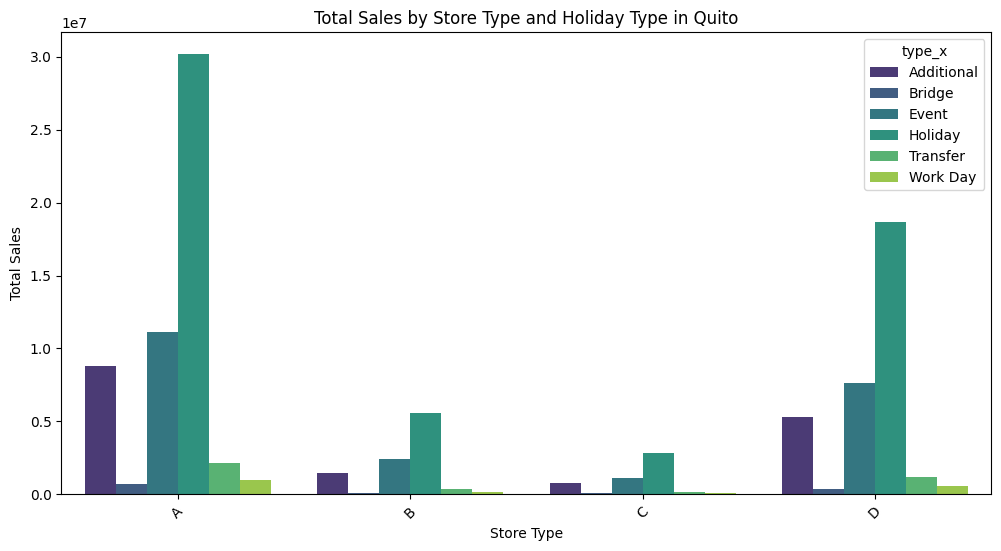

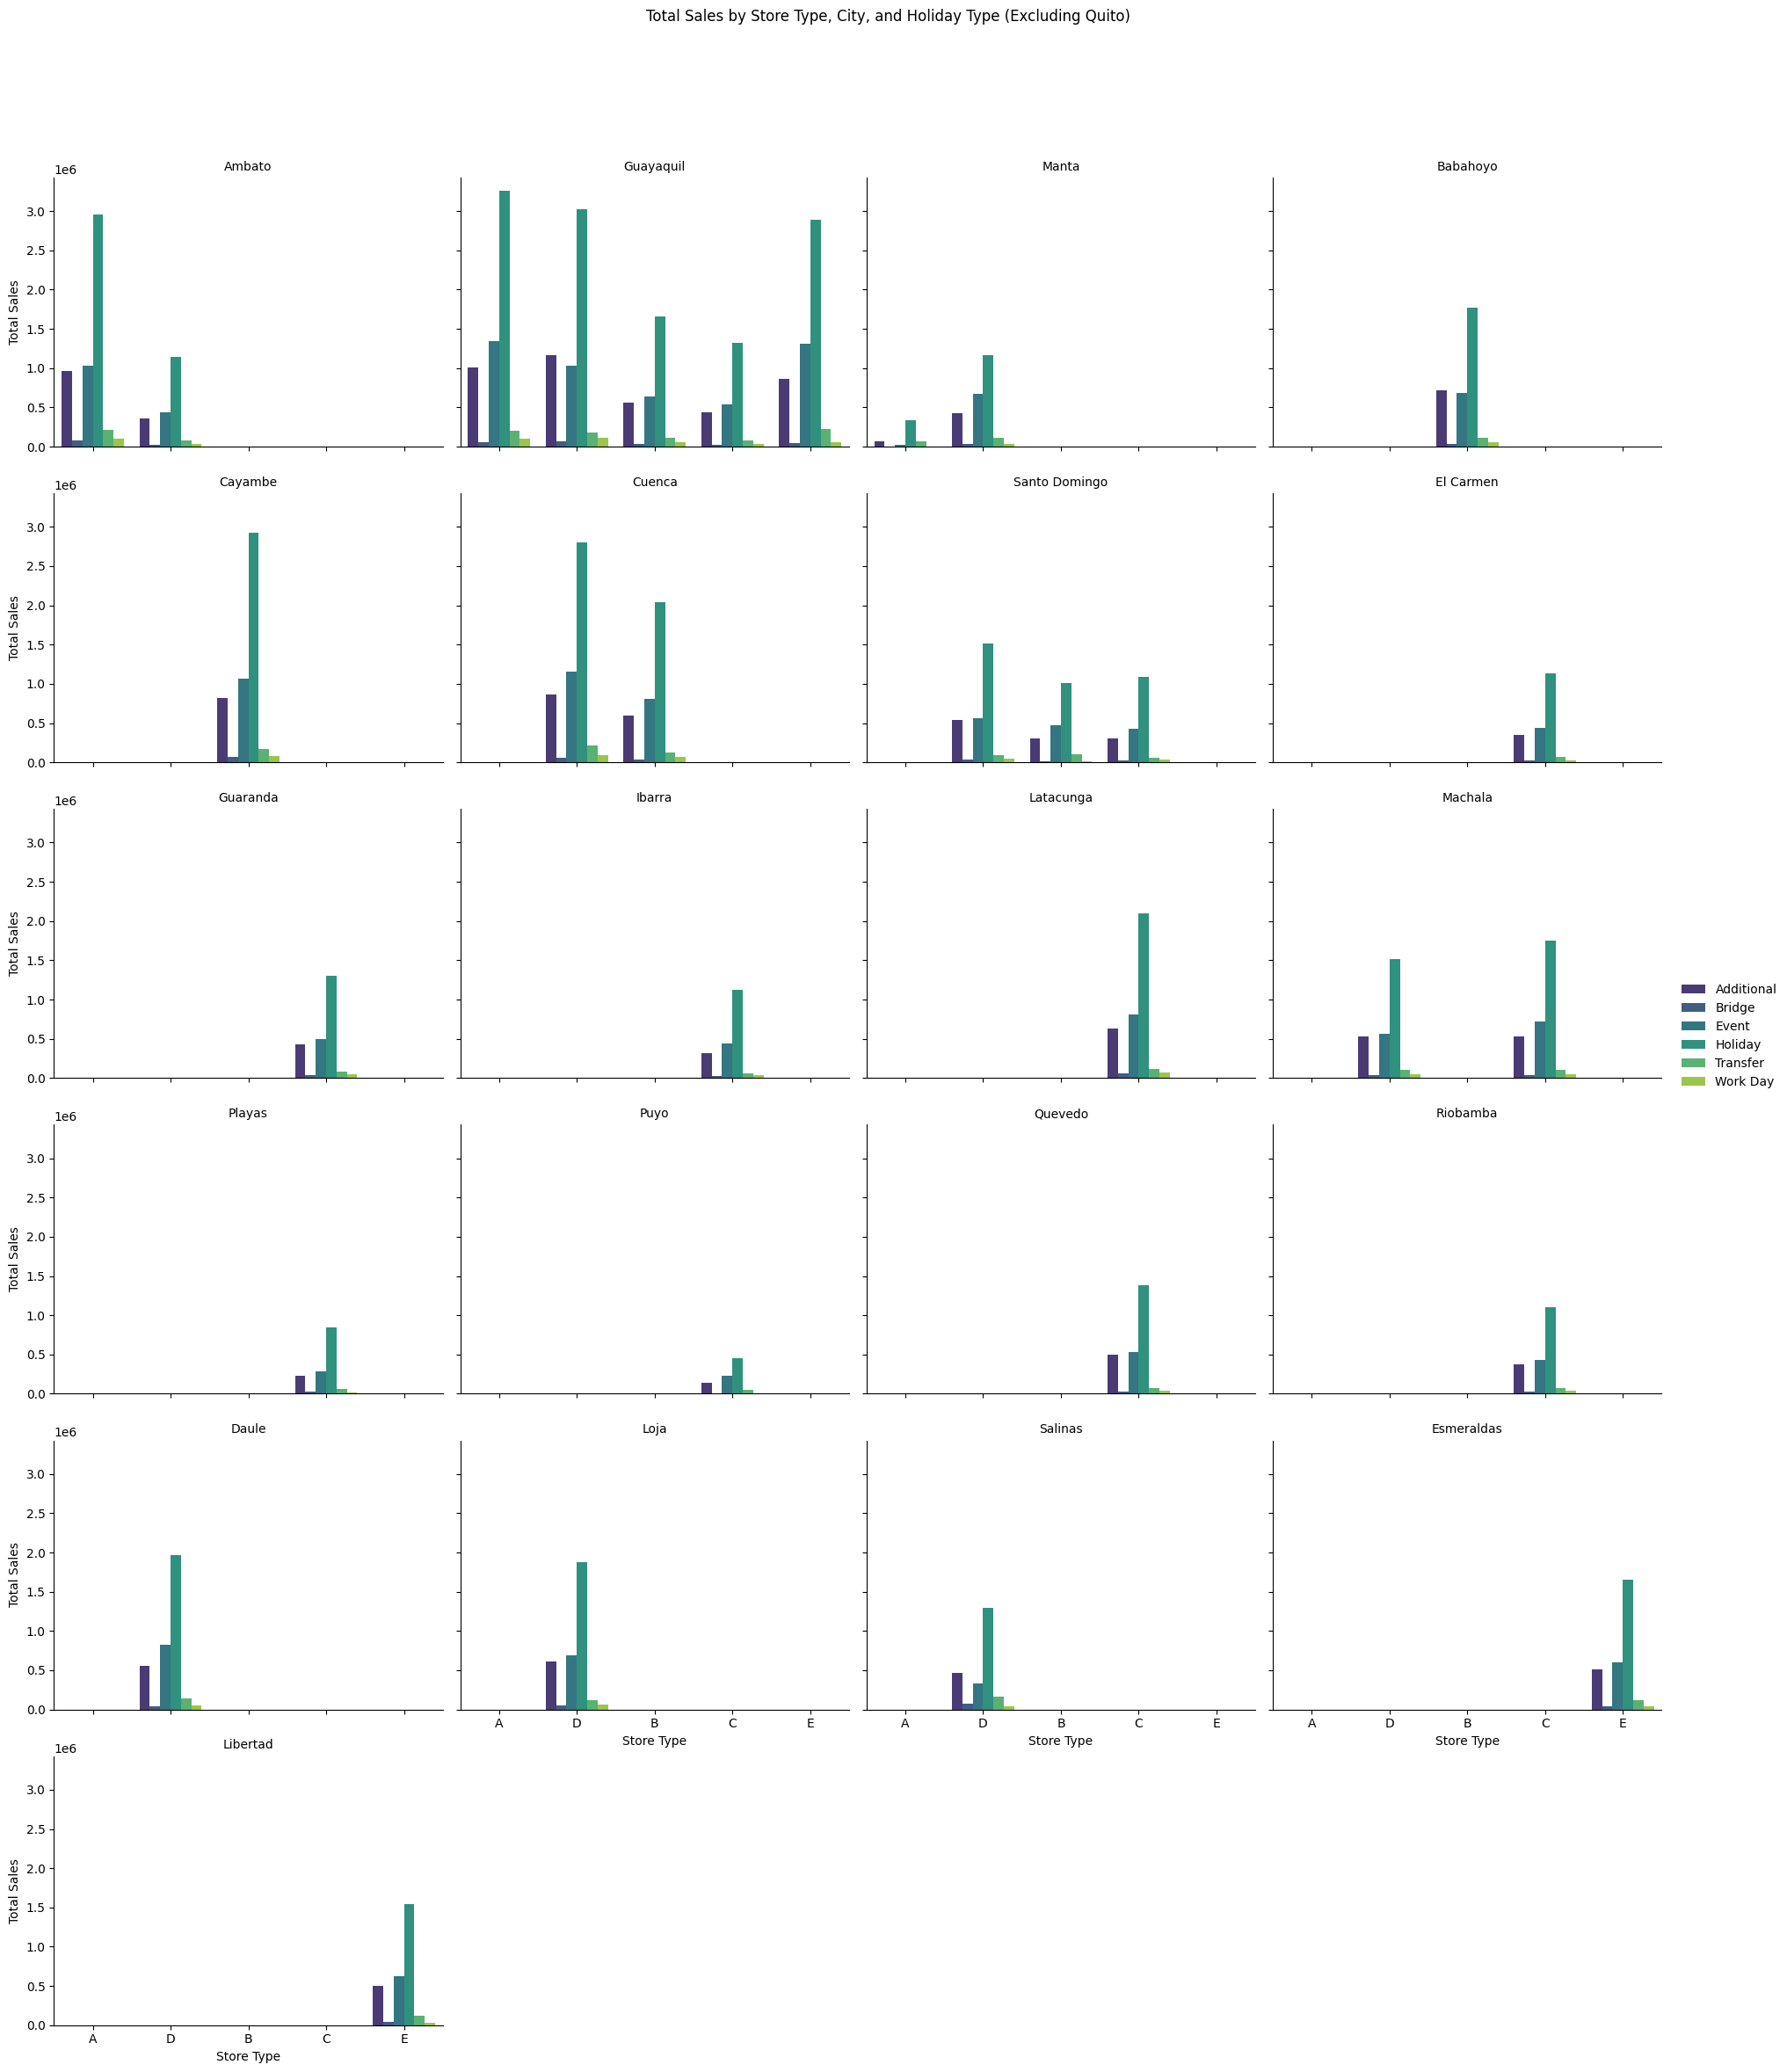

In [48]:
# Filtering data for Quito and all other cities
quito_sales = store_holiday_location_sales[store_holiday_location_sales['city'] == 'Quito']
other_cities_sales = store_holiday_location_sales[store_holiday_location_sales['city'] != 'Quito']

# Plotting sales for Quito only
plt.figure(figsize=(12, 6))
sns.barplot(data=quito_sales, x='type_y', y='sales', hue='type_x', palette='viridis')
plt.title('Total Sales by Store Type and Holiday Type in Quito')
plt.ylabel('Total Sales')
plt.xlabel('Store Type')
plt.xticks(rotation=45)
plt.show()

# Plotting sales for all other cities using FacetGrid
g = sns.FacetGrid(other_cities_sales, col='city', col_wrap=4, height=4, aspect=1.2)
g.map_dataframe(sns.barplot, x='type_y', y='sales', hue='type_x', palette='viridis', errorbar=None)
g.add_legend()
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Store Type", "Total Sales")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Total Sales by Store Type, City, and Holiday Type (Excluding Quito)')
plt.show()


#####  **Looking at Total Sales by Store Type and Holiday Type in Quito First**

- **Store Type A Dominance**: Store Type A has the highest sales in Quito, particularly during **National Holidays** and **Events**.
- **National Holidays and Events**: These holidays lead to the most significant spikes in sales, indicating their importance in driving consumer spending in Quito. Store Types B, C, and D also contribute to sales during holidays, but not to the extent of Store Type A.

##### **Observations of sales from all the other citys by Store Type and Holiday Type (FacetGrid Plot)**

- **National Holidays Lead Sales**: Across many cities, National Holidays drive the highest sales across store types. This shows that the consumer response to major national holidays is consistent beyond Quito.

- **Store Type A Consistency**: Store Type A maintains dominance across most cities, regardless of holiday type, with particularly high sales during National Holidays and Events.
- **Variation Across Cities:** In cities like Guayaquil, Cuenca, Santo Domingo, and Machala, Store Type A dominates holiday sales, similar to the trend seen in Quito.

Smaller cities such as Guaranda, Playas, and Libertad have relatively low holiday sales, indicating lower consumer activity or smaller market sizes.
##### **Insights for Feature Engineering**

- **Store Type and City-Level Interaction Feature**: Capture the interaction between **store type** and **city**, emphasizing the dominance of Store Type A.
- **Holiday Sensitivity Scores**: We could Add a feature that scores each city's sensitivity to holidays to help the model differentiate holiday effects across cities.
- **City-Level Holiday Variability**: Include a feature that represents the variation in sales during holidays for each city, capturing city-level differences.


#### Next lets look at Sales Interactions Between Promotions and Holidays
We are now going to analyze the interaction between promotions (`onpromotion`) and holidays to determine if promotions during holidays boost sales significantly compared to promotions on regular days.


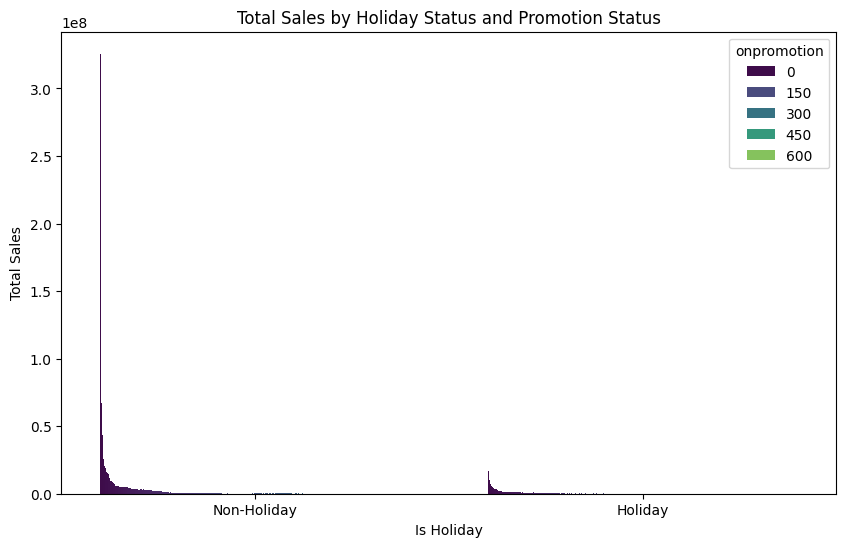

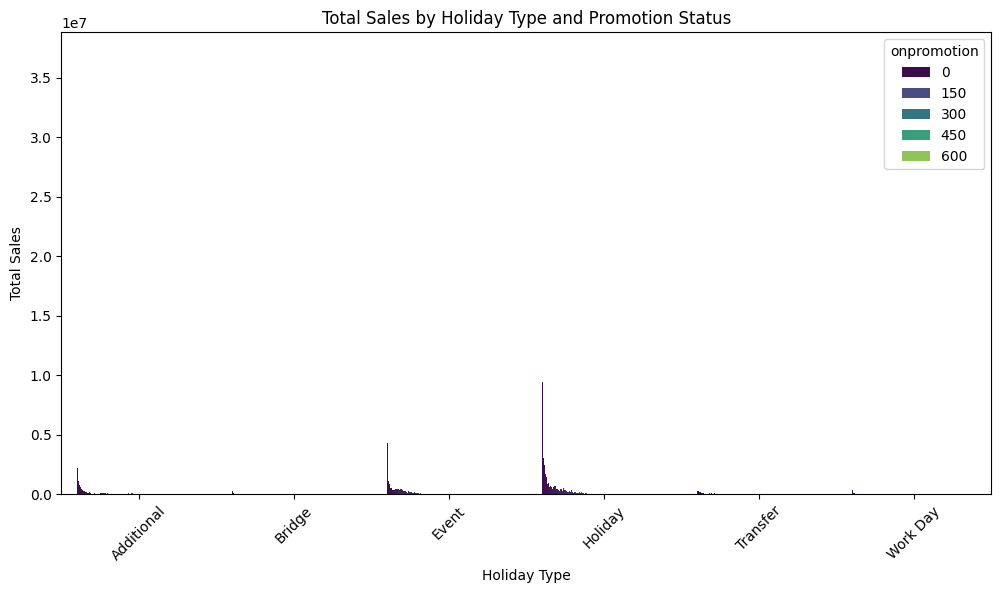

In [67]:
# Create a flag to indicate whether a date is a holiday
holiday_store_sales['is_holiday'] = holiday_store_sales['type_x'].notna()

# Grouping by holiday status and promotion status to compare sales
promotions_holidays_sales = holiday_store_sales.groupby(['is_holiday', 'onpromotion'])['sales'].sum().reset_index()

# Plotting the total sales by holiday and promotion status
plt.figure(figsize=(10, 6))
sns.barplot(data=promotions_holidays_sales, x='is_holiday', y='sales', hue='onpromotion', palette='viridis')
plt.title('Total Sales by Holiday Status and Promotion Status')
plt.ylabel('Total Sales')
plt.xlabel('Is Holiday')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.show()

# Further breakdown by holiday type and promotion status
holiday_type_promotion_sales = holiday_store_sales.groupby(['type_x', 'onpromotion'])['sales'].sum().reset_index()

# Plotting the total sales by holiday type and promotion status
plt.figure(figsize=(12, 6))
sns.barplot(data=holiday_type_promotion_sales, x='type_x', y='sales', hue='onpromotion', palette='viridis')
plt.title('Total Sales by Holiday Type and Promotion Status')
plt.ylabel('Total Sales')
plt.xlabel('Holiday Type')
plt.xticks(rotation=45)
plt.show()


##### **Looking at Total Sales by Holiday Status and Promotion Status Plot**

- **Non-Holiday Sales Dominance**: Sales are significantly higher during non-holidays, with promotions further increasing sales volumes.
- **Limited Holiday Sales Impact**: Sales during holidays are considerably lower compared to non-holidays, even with promotions.
- **Promotions Increase Sales**: Sales generally increase with more promoted items, but this trend is more significant during non-holiday periods indicating that there might not be as high of a corrolatio between holiday sales and holidy promotions.

##### **Looking at Sales by Holiday Type and Promotion Status Plot**

- **National Holidays and Events**: These holiday types see an increase in sales with promotions, indicating they are more impactful than other holidays.
- **Limited Impact on Lesser Holidays**: Holidays such as **Bridge**, **Transfer**, and **Work Days** do not show significant sales, even when promotions are active.

##### **Insights for Feature Engineering**

- There might not be a lot of value in trying to capture promotions as it realtes to holidays as the impact of promions is more prevelant during non hoiday days


#### **Summary of Conclusions for Feature Engineering around holidays**

- **Holiday Flag**: A binary feature indicating whether a date is a holiday or workday.
- **Holiday Type Feature**: Distinguishing between different holiday types (e.g., National, Regional, Local).
- **Lead-Up and Lag Effects**: Flags for days leading up to and after holidays to capture pre-holiday sales build-up and post-holiday dips.
- **Locale-Based Holiday Feature**: A feature that maps holidays to relevant stores based on the city or state of the store.
- **Holiday and Promotion Interaction Feature**: Capturing the amplified effect of promotions during holidays.
- **Seasonality and Holiday Season Flag**: A feature to capture specific holiday seasons and seasonality trends.
- **Store Type Holiday Impact**: Creating a feature that captures the holiday impact by store type, focusing on the differences seen for store types A and D.
- **Yearly Growth Rates for Major Holidays**: Including growth rates for major holidays if consistent trends are identified.


### Oil Prices Impact on Sales

Here we'll now proceed with analyzing the impact of oil prices on sales to determine if there is any correlation between the daily oil prices and total sales across stores. Since oil is a major economic factor in Ecuador, understanding this relationship is crucial to developing features that capture the effects of economic conditions on sales.

 This will help us determine if changes in oil prices influence sales patterns and by what magnitude.


<ipython-input-68-d0f4a55b48e5>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  oil_df['dcoilwtico'] = oil_df['dcoilwtico'].fillna(method='bfill')


Correlation between daily sales and oil prices: -0.07888528158090233


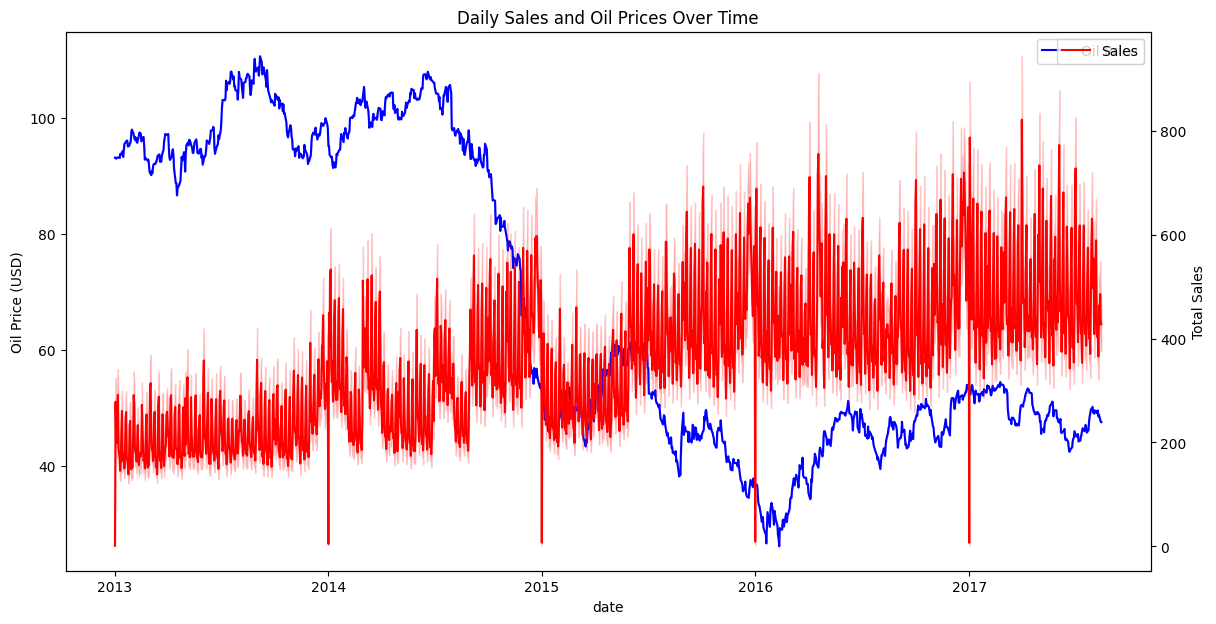

In [68]:
# Ensure that the oil_df and sales_df have dates in datetime format
oil_df['date'] = pd.to_datetime(oil_df['date'])
sales_df['date'] = pd.to_datetime(sales_df['date'])

# Impute missing oil prices using backfill (already done in previous EDA)
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].fillna(method='bfill')

# Merge the sales data with the oil data based on the date
combined_df = pd.merge(sales_df, oil_df, on='date', how='left')

# Calculating the correlation between oil prices and sales
correlation = combined_df['sales'].corr(combined_df['dcoilwtico'])
print(f"Correlation between daily sales and oil prices: {correlation}")

# Plotting oil prices and sales over time to observe their relationship
fig, ax1 = plt.subplots(figsize=(14, 7))
ax2 = ax1.twinx()

sns.lineplot(data=combined_df, x='date', y='dcoilwtico', ax=ax1, label='Oil Price', color='b')
sns.lineplot(data=combined_df, x='date', y='sales', ax=ax2, color='r', label='Sales')

ax1.set_title('Daily Sales and Oil Prices Over Time')
ax1.set_ylabel('Oil Price (USD)')
ax2.set_ylabel('Total Sales')
plt.show()


####  Daily Sales and Oil Prices Over Time observation

- **Inverse Relationship**: There appears to be an inverse relationship between oil prices and sales, with sales increasing when oil prices decrease, and vice versa. This mau not indicate correlation but that sales have a genral upward trent. We can see that between 2015 and 2016 we had the largest drop in oil price in shortest amount of time and during that time in the earler part of 2015 we can see that sales numbers also an unexpected decline. THis could indicate that there might be some senativty to sudden high spikes or dorps in oil price but generally does not have a large impact.
- **Sales Volatility**: Daily sales exhibit high volatility, suggesting other factors influence sales beyond oil prices.
- **Seasonal Spikes**: There are periodic spikes in sales, these can be attributed to the holiday spike we saw earler or promotional events.
- **Lagging Effect**: There may be a lag between changes in oil prices and their effect on sales.

## Insights for Feature Engineering

- **Oil Price Feature**: Include the daily oil price as a feature to capture economic influence on sales.
- **Lagged Oil Price Feature**: Create a lagged version of oil prices to capture delayed effects on sales.

#####  **Oil Prices and Sales Relationship in Granular 6-Month Periods**

Next we'll take a closer look at the relationship between oil prices and sales at a more granular level by breaking the data into **6-month intervals**. We'll investigate whether there is a consistent leading or lagging effect of oil prices on sales.


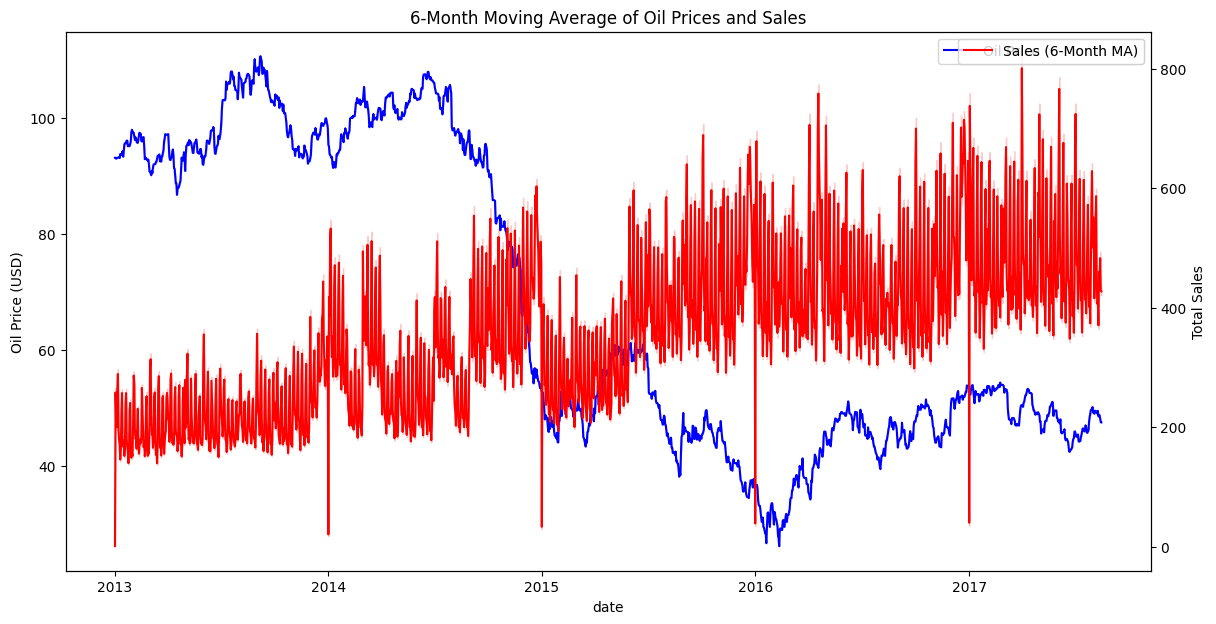

In [69]:
# Creating 6-month rolling averages for oil prices and sales
combined_df['oil_6m_ma'] = combined_df['dcoilwtico'].rolling(window=180, min_periods=1).mean()
combined_df['sales_6m_ma'] = combined_df['sales'].rolling(window=180, min_periods=1).mean()

# Plotting the 6-month rolling averages for oil prices and sales
fig, ax1 = plt.subplots(figsize=(14, 7))
ax2 = ax1.twinx()

sns.lineplot(data=combined_df, x='date', y='oil_6m_ma', ax=ax1, label='Oil Price (6-Month MA)', color='b')
sns.lineplot(data=combined_df, x='date', y='sales_6m_ma', ax=ax2, color='r', label='Sales (6-Month MA)')

ax1.set_title('6-Month Moving Average of Oil Prices and Sales')
ax1.set_ylabel('Oil Price (USD)')
ax2.set_ylabel('Total Sales')
plt.show()


In [70]:
# Splitting the data into 6-month intervals and calculating correlation for each
combined_df['6m_period'] = combined_df['date'].dt.to_period('6M')
correlations = combined_df.groupby('6m_period').apply(lambda x: x['sales'].corr(x['dcoilwtico']))

# Displaying correlation for each 6-month interval
print("Correlations between oil prices and sales for each 6-month interval:")
print(correlations)


Correlations between oil prices and sales for each 6-month interval:
6m_period
2013-01   -0.011281
2013-02    0.016400
2013-03   -0.004863
2013-04    0.013904
2013-05   -0.017801
2013-06   -0.011918
2013-07   -0.024838
2013-08    0.000236
2013-09    0.011288
2013-10    0.021663
2013-11    0.004891
2013-12    0.021528
2014-01   -0.015738
2014-02   -0.012534
2014-03    0.021882
2014-04   -0.009543
2014-05   -0.025539
2014-06   -0.016797
2014-07    0.013861
2014-08    0.014692
2014-09    0.001612
2014-10    0.028797
2014-11    0.027854
2014-12   -0.026645
2015-01    0.004524
2015-02    0.013162
2015-03    0.010238
2015-04   -0.021119
2015-05    0.000355
2015-06    0.001289
2015-07    0.024011
2015-08    0.018688
2015-09    0.006779
2015-10    0.013830
2015-11    0.035992
2015-12   -0.017146
2016-01   -0.008434
2016-02   -0.002472
2016-03   -0.023090
2016-04   -0.007667
2016-05   -0.009967
2016-06    0.001149
2016-07    0.025653
2016-08   -0.019659
2016-09   -0.012685
2016-10   -0.008813
2

<ipython-input-70-8bdfb0ce8240>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations = combined_df.groupby('6m_period').apply(lambda x: x['sales'].corr(x['dcoilwtico']))


In [71]:
# Calculating correlations between oil prices and lagged sales (7-day and 30-day lags)
combined_df['sales_lag_7'] = combined_df['sales'].shift(7)
combined_df['sales_lag_30'] = combined_df['sales'].shift(30)

# Correlation with 7-day lag
corr_lag_7 = combined_df['dcoilwtico'].corr(combined_df['sales_lag_7'])
print(f"Correlation between oil prices and sales with a 7-day lag: {corr_lag_7}")

# Correlation with 30-day lag
corr_lag_30 = combined_df['dcoilwtico'].corr(combined_df['sales_lag_30'])
print(f"Correlation between oil prices and sales with a 30-day lag: {corr_lag_30}")


Correlation between oil prices and sales with a 7-day lag: -0.0789112401514631
Correlation between oil prices and sales with a 30-day lag: -0.07871718862626309


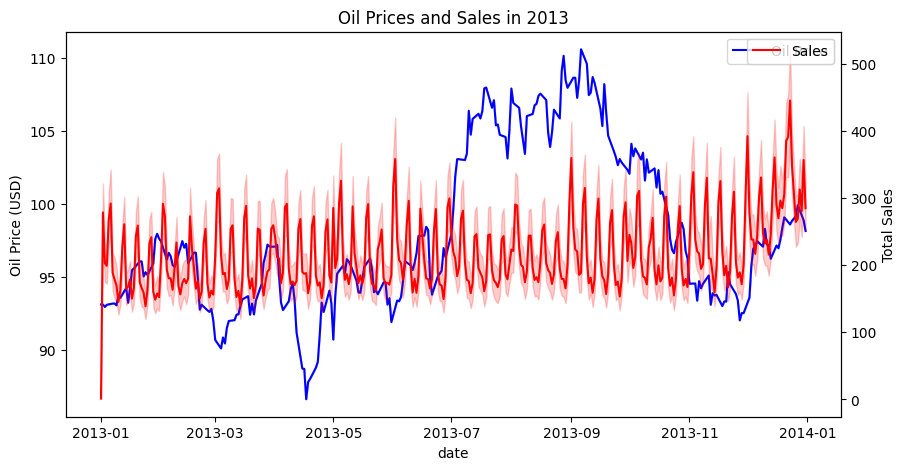

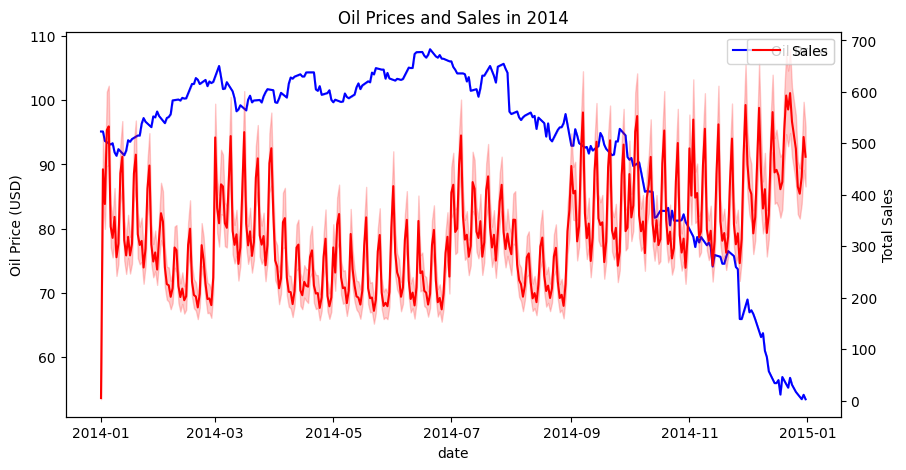

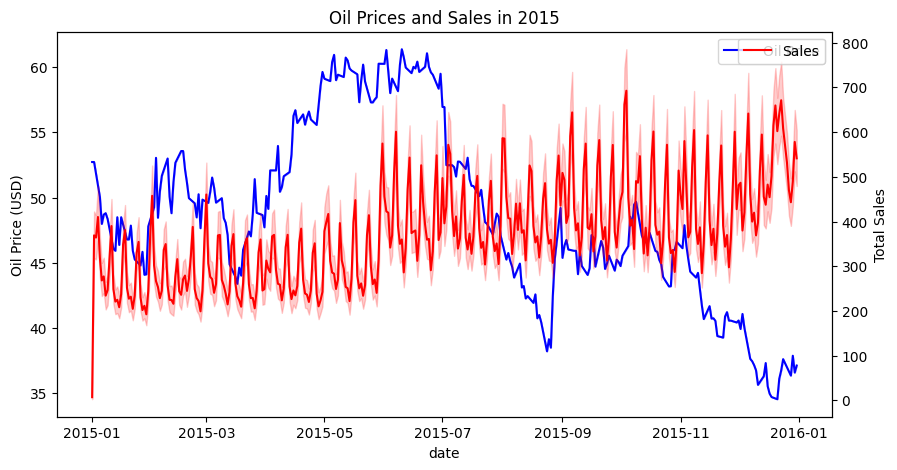

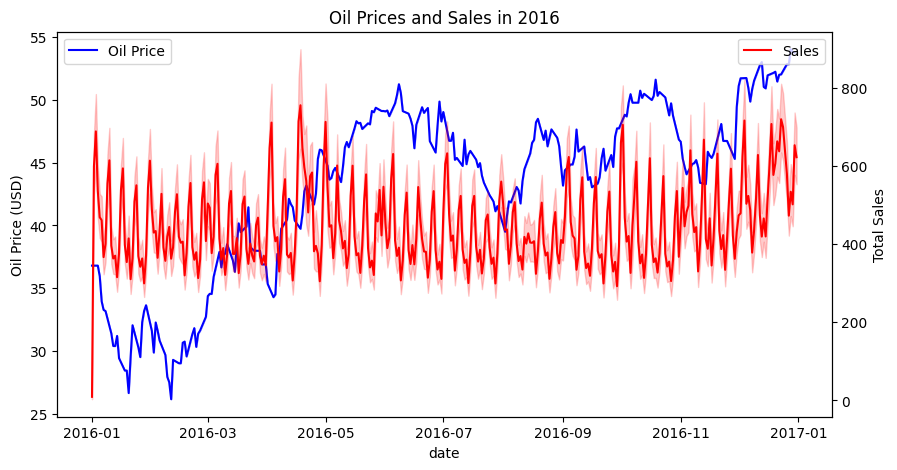

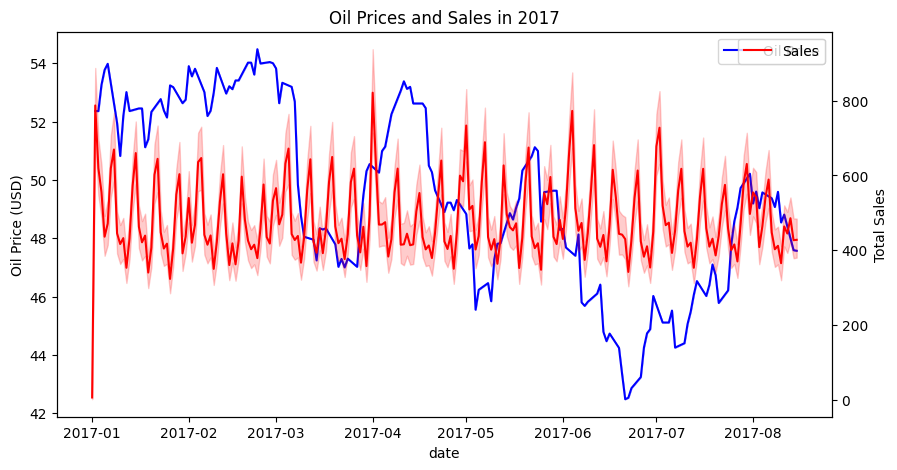

In [73]:
# Updating the time period to yearly intervals instead of 6-months
combined_df['year_period'] = combined_df['date'].dt.to_period('Y')
unique_years = combined_df['year_period'].unique()

# Plotting yearly segments to visualize detailed trends
for year in unique_years:
    year_data = combined_df[combined_df['year_period'] == year]

    # Plotting oil prices and sales for each year
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()

    sns.lineplot(data=year_data, x='date', y='dcoilwtico', ax=ax1, label='Oil Price', color='b')
    sns.lineplot(data=year_data, x='date', y='sales', ax=ax2, label='Sales', color='r')

    ax1.set_title(f'Oil Prices and Sales in {year}')
    ax1.set_ylabel('Oil Price (USD)')
    ax2.set_ylabel('Total Sales')
    plt.show()


#####  **Looking at Yearly Trends and Correlation Results**

##### Observations from Yearly Plots:
- **Year 2013**: Stable sales with no clear relationship with oil price trends.
- **Year 2014**: Significant drop in oil prices; sales did not react strongly.
- **Year 2015**: Slight lagging effect where sales increased following a drop in oil prices.
- **Year 2016 & 2017**: No consistent relationship between oil prices and sales.

##### Correlation Analysis for 6-Month Intervals:
- Correlation values between oil prices and sales fluctuate between positive and negative, but remain very small.
- This suggests a **weak linear relationship** between oil prices and sales.

##### Lag Analysis Results:
- **7-Day Lag Correlation**: `-0.0789` (weak inverse relationship).
- **30-Day Lag Correlation**: `-0.0787` (still a weak inverse relationship).

##### Insights for Feature Engineering:
- **Weak Relationship**: Oil prices do not consistently correlate with sales.
- **Lagged Effect**: Minimal effect observed even with lagged features.
- **Feature Engineering Decision**: Include **oil price** as a secondary feature, potentially add **lagged versions**, but do not expect it to be highly influential.


## Final thoughts on Data set and feature for expanded EDA Summary and Conclusions



#### 1. Sales by Store Characteristics
- **Store Type and Cluster**: Significant differences in sales were observed across different **store types** and **clusters**. Notably, Type A stores, particularly in Cluster 4, had consistently high sales.
- **Conclusion**: **Store type and cluster** are important factors in determining sales trends and will be key features for our predictive model.

#### 2. Holiday Impact on Sales
- **Holiday vs. Non-Holiday Sales**: Sales tended to be higher during **holidays** compared to non-holidays, especially during certain types of holidays (e.g., **National Holidays**).
- **Holiday Type and Sales**: **National** and **local holidays** showed a significant impact on sales compared to other holiday types, and the impact varied based on store type and location.
- **Leading and Lagging Effect of Holidays**: Sales showed notable increases leading up to major holidays, indicating that **lead-up periods** are also influential.
- **Conclusion**: **Holiday features** such as holiday type, is_leadup, and is_lag should be incorporated into our model. Specific features for **holiday proximity** could help capture the spike in sales before and during major holidays.

#### 3. Impact of Promotions on Sales
- **Sales on Holidays with Promotions**: Promotional activities had a strong influence on sales, especially during **holidays**. Sales increased significantly when promotions were combined with major holidays.
- **Conclusion**: The **interaction between holiday status and promotions** should be considered in our feature set. Including both **promotion count** and **holiday-specific promotions** as features could help better capture their combined impact on sales.

#### 4. Transactions and Sales Analysis
- **Transaction Volume Correlation**: There was a strong correlation between **daily transactions** and **sales**, varying by store. Higher transaction volumes generally led to higher sales, and this correlation was more pronounced in larger stores.
- **Conclusion**: **Transaction volumes** are a strong predictor of sales, and incorporating **daily transaction counts** as a feature is highly recommended. These features could potentially act as a proxy for store traffic.

#### 5. Oil Prices and Sales Relationship
- **Inverse Relationship Observed**: Overall, a weak **inverse relationship** was observed between **oil prices** and **sales**, especially during major drops in oil prices (e.g., 2015-2016).
- **Lag Analysis**: The **7-day and 30-day lag** correlations between oil prices and sales were both weak, suggesting minimal immediate impact of oil price changes on sales.
- **Granular Analysis by Year**: When analyzed yearly, oil prices and sales did not exhibit any consistent leading or lagging patterns, indicating that oil prices might not be a key short-term driver for store sales.
- **Conclusion**: **Oil prices** could still be used as a **secondary feature** to account for general economic conditions, but it is not expected to be a significant driver of sales patterns in this dataset.

### Key Recommendations for Feature Engineering
1. **Store Characteristics**:
   - Include **store type**, **cluster**, and **city** as categorical features.
2. **Holiday Features**:
   - Add binary features for **is_holiday**, **is_leadup**, and **is_lag**.
   - Include **holiday type** to capture the different impacts of national vs. local holidays.
3. **Promotion Features**:
   - Include **number of items on promotion**.
   - Create interaction features for **holiday and promotion** to capture the combined impact on sales.
4. **Transaction Features**:
   - Incorporate **daily transaction counts** for each store to capture customer volume and store traffic.
5. **Oil Prices**:
   - Add **oil price** as a secondary feature and include **lagged versions** to account for delayed economic effects.

### Next Steps
With the insights gained from our expanded EDA, we now have a solid foundation for **feature engineering** and **model development**. The next step is to begin engineering the features as outlined above, followed by building and testing our predictive models to forecast sales at the store level.

Let me know if you're ready to move on to feature engineering or if you have any further questions regarding the EDA.


## Release resources

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>

<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}
</script>

In [ ]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}